<a href="https://colab.research.google.com/github/ArpanSM/Machine_Learning_Hackathons/blob/master/JOB_A_THON_May_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

*** Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.) ***

[Sol1](https://github.com/krishnapriya-18/AV-JOB-A-THON-May-2021/blob/main/jobathon_may_v3.ipynb)
[Sol2](https://github.com/Manistrikes23493/AV-hackathon-May-2021/blob/main/Final%20code%20file%20.ipynb)

#Method 1

In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_eyYijxG.csv
!pip install catboost

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
def process_data():

  train = pd.read_csv("/content/train_s3TEQDk.csv")
  test = pd.read_csv("/content/test_mSzZ8RL.csv")
  
  #missing data
  dfx = pd.read_csv("/content/drive/MyDrive/Colab Weights/knn_jobathon_may_df.csv")
  dftx = pd.read_csv('/content/drive/MyDrive/Colab Weights/knn_jobathon_may_dft.csv')
  dfx['Credit_Product'] = dfx['Credit_Product'].replace(to_replace =1.0,value ="Yesx")
  dfx['Credit_Product'] = dfx['Credit_Product'].replace(to_replace =0.0,value ="Nox")
  dftx['Credit_Product'] = dftx['Credit_Product'].replace(to_replace =1.0,value ="Yesx")
  dftx['Credit_Product'] = dftx['Credit_Product'].replace(to_replace =0.0,value ="Nox")
  train['Credit_Product'] = dfx['Credit_Product']
  test['Credit_Product'] = dftx['Credit_Product']

  #Removes train rows which has Region_Code not present in test set
  test_region_list=test['Region_Code'].tolist()
  train=train[train['Region_Code'].isin(test_region_list)]
  
  #combine train & test
  train['train_or_test']='train'
  test['train_or_test']='test'
  df=pd.concat([train,test])
  df_orig = df.copy(deep = True)
  
  
  le = LabelEncoder()
  for col in ['Gender','Credit_Product','Is_Active']:
      df[col]=  df[col].astype('str')
      df[col]= le.fit_transform(df[col])

  
  df = pd.get_dummies(df,columns=['Occupation','Channel_Code'],drop_first=True)
  '''
  #one hot encoding 'Occupation'
  one_hot = pd.get_dummies(df['Occupation'])
  #df = df.drop('Occupation',axis = 1)
  df = df.join(one_hot)
  del df['Other']

  #one hot encoding 'Channel_Code'
  one_hot = pd.get_dummies(df['Channel_Code'])
  #df = df.drop('Channel_Code',axis = 1)
  df = df.join(one_hot)
  del df['X4']
  '''
  
  return train,test,df,df_orig

def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])
  
train, test, df ,df_orig = process_data()
df.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train_or_test,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
0,NNVBBKZB,0,73,RG268,43,0,1045696,0,0.0,train,1,0,0,0,1,0
1,IDD62UNG,0,30,RG277,32,0,581988,0,0.0,train,0,1,0,0,0,0
2,HD3DSEMC,0,56,RG268,26,0,1484315,1,0.0,train,0,0,1,0,1,0
3,BF3NC7KV,1,34,RG270,19,0,470454,0,0.0,train,0,1,0,0,0,0
4,TEASRWXV,0,30,RG282,33,0,886787,0,0.0,train,0,1,0,0,0,0


In [ ]:
#categorical features
cat_features=['Region_Code']
def feature_engineering0(df):
  #Interaction Feature (Combining 2 categorical features and performing frequency encoding)
  columns=['Gender','Region_Code','Credit_Product','Is_Active','Occupation_Other','Occupation_Salaried','Occupation_Self_Employed',	'Channel_Code_X2',	'Channel_Code_X3',	'Channel_Code_X4']
  comb = combinations(columns, 2) 
  for i in list(comb):  
      df[f'{i[0]}_{i[1]}']=df[i[0]].astype(str)+'_'+df[i[1]].astype(str)
      frequency_encoding(f'{i[0]}_{i[1]}',f'{i[0]}_{i[1]}',df)
      cat_features.append(f'{i[0]}_{i[1]}')

  for col in cat_features:
    df[col] = df[col].astype(str)

  return df,cat_features

df, cat_features = feature_engineering0(df)
cf = cat_features
df.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train_or_test,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Gender_Region_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Occupation_Other,Gender_Occupation_Salaried,Gender_Occupation_Self_Employed,Gender_Channel_Code_X2,Gender_Channel_Code_X3,Gender_Channel_Code_X4,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Occupation_Other,Region_Code_Occupation_Salaried,Region_Code_Occupation_Self_Employed,Region_Code_Channel_Code_X2,Region_Code_Channel_Code_X3,Region_Code_Channel_Code_X4,Credit_Product_Is_Active,Credit_Product_Occupation_Other,Credit_Product_Occupation_Salaried,Credit_Product_Occupation_Self_Employed,Credit_Product_Channel_Code_X2,Credit_Product_Channel_Code_X3,Credit_Product_Channel_Code_X4,Is_Active_Occupation_Other,Is_Active_Occupation_Salaried,Is_Active_Occupation_Self_Employed,Is_Active_Channel_Code_X2,Is_Active_Channel_Code_X3,Is_Active_Channel_Code_X4,Occupation_Other_Occupation_Salaried,Occupation_Other_Occupation_Self_Employed,Occupation_Other_Channel_Code_X2,Occupation_Other_Channel_Code_X3,Occupation_Other_Channel_Code_X4,Occupation_Salaried_Occupation_Self_Employed,Occupation_Salaried_Channel_Code_X2,Occupation_Salaried_Channel_Code_X3,Occupation_Salaried_Channel_Code_X4,Occupation_Self_Employed_Channel_Code_X2,Occupation_Self_Employed_Channel_Code_X3,Occupation_Self_Employed_Channel_Code_X4,Channel_Code_X2_Channel_Code_X3,Channel_Code_X2_Channel_Code_X4,Channel_Code_X3_Channel_Code_X4
0,NNVBBKZB,0,73,RG268,43,0,1045696,0,0.0,train,1,0,0,0,1,0,0.06429521674353415,0.3299509738289696,0.29241646891923073,0.12365078325076843,0.29272412879554005,0.2880978358406664,0.35389431883248773,0.10851562655788421,0.4445656725644305,0.09514951415377866,0.07312334597207702,0.046074915179881326,0.12071092221047924,0.07364750724282626,0.1005022262610494,0.05838985633992998,0.1426259909924025,0.40552705270384604,0.19810162461506906,0.4755851947230634,0.4325669373883665,0.5254203972800588,0.17440611673413345,0.6937815671852254,0.1680022333828058,0.3847998928887838,0.3990234647629737,0.47642556197779723,0.13628477909736011,0.5977745935613625,0.2857362614197364,0.2857362614197364,0.2065508764033421,0.10395485376185416,0.28028099602036255,0.2963989550959016,0.44561399510592903,0.2599213188353364,0.6866284750610334,0.4913527633839168,0.12863886143056144,0.5813974025530072,0.27911872537652727,0.7013021419394537,0.27911872537652727
1,IDD62UNG,0,30,RG277,32,0,581988,0,0.0,train,0,1,0,0,0,0,0.024100023644231236,0.3299509738289696,0.29241646891923073,0.3296774983833613,0.16060415283858967,0.2880978358406664,0.35389431883248773,0.34481265507624553,0.4445656725644305,0.039175357583388644,0.035682848246766014,0.03870532166124938,0.01827442691226281,0.032329925335505945,0.03936052324968593,0.03984195398205887,0.05136495583086683,0.40552705270384604,0.5078410537920504,0.2303574836840561,0.4325669373883665,0.5254203972800588,0.531536561672986,0.6937815671852254,0.441867951241607,0.225070291735629,0.3990234647629737,0.47642556197779723,0.4735854055270527,0.5977745935613625,0.2931656776920951,0.30382837136826035,0.5174041482806656,0.5390998669655905,0.6970661212350835,0.2931656776920951,0.27834102957807866,0.27396827115090433,0.29071864219441257,0.4913527633839168,0.46092577135743523,0.5813974025530072,0.4448362993074804,0.7013021419394537,0.6982283918789187
2,HD3DSEMC,0,56,RG268,26,0,1484315,1,0.0,train,0,0,1,0,1,0,0.06429521674353415,0.3299509738289696,0.160911812714899,0.3296774983833613,0.29272412879554005,0.16523044579346335,0.35389431883248773,0.10851562655788421,0.4445656725644305,0.09514951415377866,0.0723285579582779,0.0993769887504736,0.12071092221047924,0.07180439668752867,0.1005022262610494,0.05838985633992998,0.1426259909924025,0.30041562570327346,0.5078410537920504,0.4755851947230634,0.273375741018753,0.5254203972800588,0.17440611673413345,0.6937815671852254,0.2723

In [ ]:
df.shape

(351037, 61)

In [ ]:
cat_features

['Region_Code',
 'Gender_Region_Code',
 'Gender_Credit_Product',
 'Gender_Is_Active',
 'Gender_Occupation_Other',
 'Gender_Occupation_Salaried',
 'Gender_Occupation_Self_Employed',
 'Gender_Channel_Code_X2',
 'Gender_Channel_Code_X3',
 'Gender_Channel_Code_X4',
 'Region_Code_Credit_Product',
 'Region_Code_Is_Active',
 'Region_Code_Occupation_Other',
 'Region_Code_Occupation_Salaried',
 'Region_Code_Occupation_Self_Employed',
 'Region_Code_Channel_Code_X2',
 'Region_Code_Channel_Code_X3',
 'Region_Code_Channel_Code_X4',
 'Credit_Product_Is_Active',
 'Credit_Product_Occupation_Other',
 'Credit_Product_Occupation_Salaried',
 'Credit_Product_Occupation_Self_Employed',
 'Credit_Product_Channel_Code_X2',
 'Credit_Product_Channel_Code_X3',
 'Credit_Product_Channel_Code_X4',
 'Is_Active_Occupation_Other',
 'Is_Active_Occupation_Salaried',
 'Is_Active_Occupation_Self_Employed',
 'Is_Active_Channel_Code_X2',
 'Is_Active_Channel_Code_X3',
 'Is_Active_Channel_Code_X4',
 'Occupation_Other_Occupatio

In [ ]:
cat_features = ['Region_Code',
 'Gender_Region_Code',
 'Gender_Credit_Product',
 'Gender_Is_Active',
 'Gender_Occupation_Other',
 'Gender_Occupation_Salaried',
 'Gender_Occupation_Self_Employed',
 'Gender_Channel_Code_X2',
 'Gender_Channel_Code_X3',
 'Gender_Channel_Code_X4',
 'Region_Code_Credit_Product',
 'Region_Code_Is_Active',
 'Region_Code_Occupation_Other',
 'Region_Code_Occupation_Salaried',
 'Region_Code_Occupation_Self_Employed',
 'Region_Code_Channel_Code_X2',
 'Region_Code_Channel_Code_X3',
 'Region_Code_Channel_Code_X4',
 'Credit_Product_Is_Active',
 'Credit_Product_Occupation_Other',
 'Credit_Product_Occupation_Salaried',
 'Credit_Product_Occupation_Self_Employed',
 'Credit_Product_Channel_Code_X2',
 'Credit_Product_Channel_Code_X3',
 'Credit_Product_Channel_Code_X4',
 'Is_Active_Occupation_Other',
 'Is_Active_Occupation_Salaried',
 'Is_Active_Occupation_Self_Employed',
 'Is_Active_Channel_Code_X2',
 'Is_Active_Channel_Code_X3',
 'Is_Active_Channel_Code_X4',
 'Occupation_Other_Occupation_Salaried',
 'Occupation_Other_Occupation_Self_Employed',
 'Occupation_Other_Channel_Code_X2',
 'Occupation_Other_Channel_Code_X3',
 'Occupation_Other_Channel_Code_X4',
 'Occupation_Salaried_Occupation_Self_Employed',
 'Occupation_Salaried_Channel_Code_X2',
 'Occupation_Salaried_Channel_Code_X3',
 'Occupation_Salaried_Channel_Code_X4',
 'Occupation_Self_Employed_Channel_Code_X2',
 'Occupation_Self_Employed_Channel_Code_X3',
 'Occupation_Self_Employed_Channel_Code_X4',
 'Channel_Code_X2_Channel_Code_X3',
 'Channel_Code_X2_Channel_Code_X4',
 'Channel_Code_X3_Channel_Code_X4']

cf = cat_features

In [ ]:
df.to_csv("df_FE_jobathon_may2021.csv",index=False)
df_orig.to_csv("df_orig_jobathon_may2021.csv",index=False)
train.to_csv("train_jobathon_may2021.csv",index=False)
test.to_csv("test_jobathon_may2021.csv",index=False)
!cp '/content/df_FE_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'
!cp '/content/df_orig_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'
!cp '/content/train_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'
!cp '/content/test_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'

In [ ]:
df.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train_or_test,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Gender_Region_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Occupation_Other,Gender_Occupation_Salaried,Gender_Occupation_Self_Employed,Gender_Channel_Code_X2,Gender_Channel_Code_X3,Gender_Channel_Code_X4,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Occupation_Other,Region_Code_Occupation_Salaried,Region_Code_Occupation_Self_Employed,Region_Code_Channel_Code_X2,Region_Code_Channel_Code_X3,Region_Code_Channel_Code_X4,Credit_Product_Is_Active,Credit_Product_Occupation_Other,Credit_Product_Occupation_Salaried,Credit_Product_Occupation_Self_Employed,Credit_Product_Channel_Code_X2,Credit_Product_Channel_Code_X3,Credit_Product_Channel_Code_X4,Is_Active_Occupation_Other,Is_Active_Occupation_Salaried,Is_Active_Occupation_Self_Employed,Is_Active_Channel_Code_X2,Is_Active_Channel_Code_X3,Is_Active_Channel_Code_X4,Occupation_Other_Occupation_Salaried,Occupation_Other_Occupation_Self_Employed,Occupation_Other_Channel_Code_X2,Occupation_Other_Channel_Code_X3,Occupation_Other_Channel_Code_X4,Occupation_Salaried_Occupation_Self_Employed,Occupation_Salaried_Channel_Code_X2,Occupation_Salaried_Channel_Code_X3,Occupation_Salaried_Channel_Code_X4,Occupation_Self_Employed_Channel_Code_X2,Occupation_Self_Employed_Channel_Code_X3,Occupation_Self_Employed_Channel_Code_X4,Channel_Code_X2_Channel_Code_X3,Channel_Code_X2_Channel_Code_X4,Channel_Code_X3_Channel_Code_X4
0,NNVBBKZB,0,73,RG268,43,0,1045696,0,0.0,train,1,0,0,0,1,0,0.064295,0.329951,0.292416,0.123651,0.292724,0.288098,0.353894,0.108516,0.444566,0.095150,0.073123,0.046075,0.120711,0.073648,0.100502,0.058390,0.142626,0.405527,0.198102,0.475585,0.432567,0.52542,0.174406,0.693782,0.168002,0.384800,0.399023,0.476426,0.136285,0.597775,0.285736,0.285736,0.206551,0.103955,0.280281,0.296399,0.445614,0.259921,0.686628,0.491353,0.128639,0.581397,0.279119,0.701302,0.279119
1,IDD62UNG,0,30,RG277,32,0,581988,0,0.0,train,0,1,0,0,0,0,0.024100,0.329951,0.292416,0.329677,0.160604,0.288098,0.353894,0.344813,0.444566,0.039175,0.035683,0.038705,0.018274,0.032330,0.039361,0.039842,0.051365,0.405527,0.507841,0.230357,0.432567,0.52542,0.531537,0.693782,0.441868,0.225070,0.399023,0.476426,0.473585,0.597775,0.293166,0.303828,0.517404,0.539100,0.697066,0.293166,0.278341,0.273968,0.290719,0.491353,0.460926,0.581397,0.444836,0.701302,0.698228
2,HD3DSEMC,0,56,RG268,26,0,1484315,1,0.0,train,0,0,1,0,1,0,0.064295,0.329951,0.160912,0.329677,0.292724,0.165230,0.353894,0.108516,0.444566,0.095150,0.072329,0.099377,0.120711,0.071804,0.100502,0.058390,0.142626,0.300416,0.507841,0.475585,0.273376,0.52542,0.174406,0.693782,0.272396,0.322034,0.199589,0.247529,0.142834,0.379573,0.421098,0.410435,0.517404,0.175164,0.697066,0.410435,0.445614,0.259921,0.686628,0.232602,0.150480,0.395950,0.279119,0.701302,0.279119
3,BF3NC7KV,1,34,RG270,19,0,470454,0,0.0,train,0,1,0,0,0,0,0.016084,0.375992,0.317454,0.384586,0.132562,0.301467,0.370061,0.376069,0.532781,0.025314,0.024200,0.024166,0.014782,0.022508,0.026923,0.027903,0.031068,0.405527,0.507841,0.230357,0.432567,0.52542,0.531537,0.693782,0.441868,0.225070,0.399023,0.476426,0.473585,0.597775,0.293166,0.303828,0.517404,0.539100,0.697066,0.293166,0.278341,0.273968,0.290719,0.491353,0.460926,0.581397,0.444836,0.701302,0.698228
4,TEASRWXV,0,30,RG282,33,0,886787,0,0.0,train,0,1,0,0,0,0,0.010395,0.329951,0.292416,0.329677,0.160604,0.288098,0.353894,0.344813,0.444566,0.017830,0.016320,0.016978,0.008851,0.015283,0.017454,0.019160,0.022784,0.405527,0.507841,0.230357,0.432567,0.52542,0.531537,0.693782,0.441868,0.225070,0.399023,0.476426,0.473585,0.597775,0.293166,0.303828,0.517404,0.539100,0.697066,0.293166,0.278341,0.273968,0.290719,0.491353,0.460926,0.581397,0.444836,0.701302,0.698228


In [ ]:
def feature_engineering1(df):
    
  #Frequency Encoding of categorical data
  df['Occupation'] = df_orig['Occupation'].values
  df['Channel_Code'] = df_orig['Channel_Code'].values
  frequency_encoding('Gender','Gender_fe',df)
  frequency_encoding('Region_Code','Region_Code_fe',df)
  frequency_encoding('Credit_Product','Credit_Product_fe',df)
  frequency_encoding('Is_Active','Is_Active_fe',df)
  frequency_encoding('Occupation','Occupation_fe',df)
  frequency_encoding('Channel_Code','Channel_Code_fe',df)
  return df
cf.append('Occupation')
cf.append('Channel_Code')
df = feature_engineering1(df)
df.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train_or_test,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Gender_Region_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Occupation_Other,Gender_Occupation_Salaried,Gender_Occupation_Self_Employed,Gender_Channel_Code_X2,Gender_Channel_Code_X3,Gender_Channel_Code_X4,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Occupation_Other,Region_Code_Occupation_Salaried,Region_Code_Occupation_Self_Employed,Region_Code_Channel_Code_X2,Region_Code_Channel_Code_X3,Region_Code_Channel_Code_X4,Credit_Product_Is_Active,Credit_Product_Occupation_Other,Credit_Product_Occupation_Salaried,Credit_Product_Occupation_Self_Employed,Credit_Product_Channel_Code_X2,Credit_Product_Channel_Code_X3,Credit_Product_Channel_Code_X4,Is_Active_Occupation_Other,Is_Active_Occupation_Salaried,Is_Active_Occupation_Self_Employed,Is_Active_Channel_Code_X2,Is_Active_Channel_Code_X3,Is_Active_Channel_Code_X4,Occupation_Other_Occupation_Salaried,Occupation_Other_Occupation_Self_Employed,Occupation_Other_Channel_Code_X2,Occupation_Other_Channel_Code_X3,Occupation_Other_Channel_Code_X4,Occupation_Salaried_Occupation_Self_Employed,Occupation_Salaried_Channel_Code_X2,Occupation_Salaried_Channel_Code_X3,Occupation_Salaried_Channel_Code_X4,Occupation_Self_Employed_Channel_Code_X2,Occupation_Self_Employed_Channel_Code_X3,Occupation_Self_Employed_Channel_Code_X4,Channel_Code_X2_Channel_Code_X3,Channel_Code_X2_Channel_Code_X4,Channel_Code_X3_Channel_Code_X4,Occupation,Channel_Code,Gender_fe,Region_Code_fe,Credit_Product_fe,Is_Active_fe,Occupation_fe,Channel_Code_fe
0,NNVBBKZB,0,73,RG268,43,0,1045696,0,0.0,train,1,0,0,0,1,0,0.064295,0.329951,0.292416,0.123651,0.292724,0.288098,0.353894,0.108516,0.444566,0.095150,0.073123,0.046075,0.120711,0.073648,0.100502,0.058390,0.142626,0.405527,0.198102,0.475585,0.432567,0.52542,0.174406,0.693782,0.168002,0.384800,0.399023,0.476426,0.136285,0.597775,0.285736,0.285736,0.206551,0.103955,0.280281,0.296399,0.445614,0.259921,0.686628,0.491353,0.128639,0.581397,0.279119,0.701302,0.279119,Other,X3,0.453328,0.145452,0.705943,0.60987,0.285736,0.279119
1,IDD62UNG,0,30,RG277,32,0,581988,0,0.0,train,0,1,0,0,0,0,0.024100,0.329951,0.292416,0.329677,0.160604,0.288098,0.353894,0.344813,0.444566,0.039175,0.035683,0.038705,0.018274,0.032330,0.039361,0.039842,0.051365,0.405527,0.507841,0.230357,0.432567,0.52542,0.531537,0.693782,0.441868,0.225070,0.399023,0.476426,0.473585,0.597775,0.293166,0.303828,0.517404,0.539100,0.697066,0.293166,0.278341,0.273968,0.290719,0.491353,0.460926,0.581397,0.444836,0.701302,0.698228,Salaried,X1,0.453328,0.052479,0.705943,0.60987,0.293166,0.422183
2,HD3DSEMC,0,56,RG268,26,0,1484315,1,0.0,train,0,0,1,0,1,0,0.064295,0.329951,0.160912,0.329677,0.292724,0.165230,0.353894,0.108516,0.444566,0.095150,0.072329,0.099377,0.120711,0.071804,0.100502,0.058390,0.142626,0.300416,0.507841,0.475585,0.273376,0.52542,0.174406,0.693782,0.272396,0.322034,0.199589,0.247529,0.142834,0.379573,0.421098,0.410435,0.517404,0.175164,0.697066,0.410435,0.445614,0.259921,0.686628,0.232602,0.150480,0.395950,0.279119,0.701302,0.279119,Self_Employed,X3,0.453328,0.145452,0.705943,0.39013,0.410435,0.279119
3,BF3NC7KV,1,34,RG270,19,0,470454,0,0.0,train,0,1,0,0,0,0,0.016084,0.375992,0.317454,0.384586,0.132562,0.301467,0.370061,0.376069,0.532781,0.025314,0.024200,0.024166,0.014782,0.022508,0.026923,0.027903,0.031068,0.405527,0.507841,0.230357,0.432567,0.52542,0.531537,0.693782,0.441868,0.225070,0.399023,0.476426,0.473585,0.597775,0.293166,0.303828,0.517404,0.539100,0.697066,0.293166,0.278341,0.273968,0.290719,0.491353,0.460926,0.581397,0.444836,0.701302,0.698228,Salaried,X1,0.546672,0.031792,0.705943,0.60987,0.293166,0.422183
4,TEASRWXV,0,30,RG282,33,0,886787,0,0.0,train,0,1,0,0,0,0,0.010395,0.329951,0.292416,0.329677,0.160604,0.288098,0.353894,0.344813,0.444566,0.017830,0.016320,0.016978,0.008851,0.015

In [ ]:
df.to_csv("df_FE_jobathon_may2021.csv",index=False)
!cp '/content/df_FE_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'

In [ ]:
df = pd.read_csv("df_FE_jobathon_may2021.csv")
train = pd.read_csv("/content/train_s3TEQDk.csv")
test = pd.read_csv("/content/test_mSzZ8RL.csv")

In [ ]:
def feature_engineering2(df):
  #Deriving characteristics of each Region by creating aggregate features
  
  Region_aggregate_features = df.groupby(['Region_Code']).agg(
                                                   {'Age': ['mean', 'max', 'min','std','sum'],
                                                    'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Avg_Account_Balance': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Occupation': ['nunique','count'] ,
                                                    'Channel_Code': ['nunique','count'] ,
                                                    })
  Region_aggregate_features.columns = ['Region_aggregate_features_' + '_'.join(c).strip('_') for c in Region_aggregate_features.columns]
  df = pd.merge(df, Region_aggregate_features, on = ['Region_Code'], how='left')

  
  Region_occupation_aggregate_features = df.groupby(['Region_Code','Occupation']).agg(
                                                    {'Age': ['mean', 'max', 'min','std','sum'],
                                                    'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Avg_Account_Balance': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Channel_Code': ['nunique','count'] ,
                                                    })
  Region_occupation_aggregate_features.columns = ['Region_occupation_aggregate_features_' + '_'.join(c).strip('_') for c in Region_occupation_aggregate_features.columns]
  df = pd.merge(df, Region_occupation_aggregate_features, on = ['Region_Code','Occupation'], how='left')

  
  Region_channel_code_aggregate_features = df.groupby(['Region_Code','Channel_Code']).agg(
                                                    {'Age': ['mean', 'max', 'min','std','sum'],
                                                    'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Avg_Account_Balance': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Occupation': ['nunique','count'] ,
                                                    })
  Region_channel_code_aggregate_features.columns = ['Region_channel_code_aggregate_features' + '_'.join(c).strip('_') for c in Region_channel_code_aggregate_features.columns]
  df = pd.merge(df, Region_channel_code_aggregate_features, on = ['Region_Code','Channel_Code'], how='left')
  
  '''
  for i in cat_features:
    df[f'Region_{i}_max']=df.groupby('Region_Code')[i].transform('max')
    df[f'Region_{i}_min']=df.groupby('Region_Code')[i].transform('min')
    df[f'Region_{i}_mean']=df.groupby('Region_Code')[i].transform('mean')
    df[f'Region_{i}_std']=df.groupby('Region_Code')[i].transform('std')


    df[f'Region_Occupation_{i}_max']=df.groupby(['Region_Code','Occupation'])[i].transform('max')
    df[f'Region_Occupation_{i}_min']=df.groupby(['Region_Code','Occupation'])[i].transform('min')
    df[f'Region_Occupation_{i}_mean']=df.groupby(['Region_Code','Occupation'])[i].transform('mean')
    df[f'Region_Occupation_{i}_std']=df.groupby(['Region_Code','Occupation'])[i].transform('std')


    df[f'Region_Channel_Code_{i}_max']=df.groupby(['Region_Code','Channel_Code'])[i].transform('max')
    df[f'Region_Channel_Code_{i}_min']=df.groupby(['Region_Code','Channel_Code'])[i].transform('min')
    df[f'Region_Channel_Code_{i}_mean']=df.groupby(['Region_Code','Channel_Code'])[i].transform('mean')
    df[f'Region_Channel_Code_{i}_std']=df.groupby(['Region_Code','Channel_Code'])[i].transform('std')
  '''

  
  #Creating Age Bins and deriving characteristics of each age group by creating aggregate features  
  Age_Bins = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
  df['Age_Bins'] =Age_Bins.fit_transform(df['Age'].values.reshape(-1,1)).astype(int)
  
  age_aggregate_features = df.groupby(['Age_Bins']).agg({'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Avg_Account_Balance': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Occupation': ['nunique','count'] ,
                                                    'Channel_Code': ['nunique','count'] ,
                                                    })

  age_aggregate_features.columns = ['age_aggregate_features' + '_'.join(c).strip('_') for c in age_aggregate_features.columns]
  df = pd.merge(df, age_aggregate_features, on = ['Age_Bins'], how='left')

  #Creating Avg_Account_Balance Bins and deriving characteristics of each Avg_Account_Balance group by creating aggregate features  
  Avg_Account_Balance_Bins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
  df['Avg_Account_Balance_Bins'] =Avg_Account_Balance_Bins.fit_transform(df['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)
  
  Avg_Account_Balance_aggregate_features = df.groupby(['Avg_Account_Balance_Bins']).agg(
                                                    {'Age': ['mean', 'max', 'min','std','sum'], 
                                                    'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Occupation': ['nunique','count'] ,
                                                    'Channel_Code': ['nunique','count'] ,
                                                    })

  Avg_Account_Balance_aggregate_features.columns = ['Avg_Account_Balance_aggregate_features' + '_'.join(c).strip('_') for c in Avg_Account_Balance_aggregate_features.columns]
  df = pd.merge(df, Avg_Account_Balance_aggregate_features, on = ['Avg_Account_Balance_Bins'], how='left')

  
  #Deriving characteristics of Occupation by creating aggregate features
  
  Occupation_aggregate_features = df.groupby(['Occupation']).agg(
                                                    {'Age': ['mean', 'max', 'min','std','sum'],
                                                    'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Avg_Account_Balance': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Channel_Code': ['nunique','count'] ,
                                                    })
  Occupation_aggregate_features.columns = ['Occupation_aggregate_features' + '_'.join(c).strip('_') for c in Occupation_aggregate_features.columns]
  df = pd.merge(df, Occupation_aggregate_features, on = ['Occupation'], how='left')
  
  #Deriving characteristics of Channel_Code by creating aggregate features
  
  Channel_Code_aggregate_features = df.groupby(['Channel_Code']).agg(
                                                    {'Age': ['mean', 'max', 'min','std','sum'],
                                                    'Vintage': ['mean', 'max', 'min','std','sum'], 
                                                    'Avg_Account_Balance': ['mean', 'max', 'min','std','sum'], 
                                                    'Gender': ['nunique','count'], 
                                                    'Credit_Product': ['nunique','count'],
                                                    'Is_Active': ['nunique','count'] ,
                                                    'Occupation': ['nunique','count'] ,
                                                    })
  
  Channel_Code_aggregate_features.columns = ['Channel_Code_aggregate_features' + '_'.join(c).strip('_') for c in Channel_Code_aggregate_features.columns]
  df = pd.merge(df, Channel_Code_aggregate_features, on = ['Channel_Code'], how='left')

  

  for col in cat_features:
    df[col] = df[col].astype(str)

  return df,cat_features

df, cat_features= feature_engineering2(df)
df.head()

,ID,Gender,Age,Region_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train_or_test,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Gender_Region_Code,Gender_Credit_Product,Gender_Is_Active,Gender_Occupation_Other,Gender_Occupation_Salaried,Gender_Occupation_Self_Employed,Gender_Channel_Code_X2,Gender_Channel_Code_X3,Gender_Channel_Code_X4,Region_Code_Credit_Product,Region_Code_Is_Active,Region_Code_Occupation_Other,Region_Code_Occupation_Salaried,Region_Code_Occupation_Self_Employed,Region_Code_Channel_Code_X2,Region_Code_Channel_Code_X3,Region_Code_Channel_Code_X4,Credit_Product_Is_Active,Credit_Product_Occupation_Other,Credit_Product_Occupation_Salaried,Credit_Product_Occupation_Self_Employed,Credit_Product_Channel_Code_X2,Credit_Product_Channel_Code_X3,Credit_Product_Channel_Code_X4,...,Occupation_aggregate_featuresVintage_max,Occupation_aggregate_featuresVintage_min,Occupation_aggregate_featuresVintage_std,Occupation_aggregate_featuresVintage_sum,Occupation_aggregate_featuresAvg_Account_Balance_mean,Occupation_aggregate_featuresAvg_Account_Balance_max,Occupation_aggregate_featuresAvg_Account_Balance_min,Occupation_aggregate_featuresAvg_Account_Balance_std,Occupation_aggregate_featuresAvg_Account_Balance_sum,Occupation_aggregate_featuresGender_nunique,Occupation_aggregate_featuresGender_count,Occupation_aggregate_featuresCredit_Product_nunique,Occupation_aggregate_featuresCredit_Product_count,Occupation_aggregate_featuresIs_Active_nunique,Occupation_aggregate_featuresIs_Active_count,Occupation_aggregate_featuresChannel_Code_nunique,Occupation_aggregate_featuresChannel_Code_count,Channel_Code_aggregate_featuresAge_mean,Channel_Code_aggregate_featuresAge_max,Channel_Code_aggregate_featuresAge_min,Channel_Code_aggregate_featuresAge_std,Channel_Code_aggregate_featuresAge_sum,Channel_Code_aggregate_featuresVintage_mean,Channel_Code_aggregate_featuresVintage_max,Channel_Code_aggregate_featuresVintage_min,Channel_Code_aggregate_featuresVintage_std,Channel_Code_aggregate_featuresVintage_sum,Channel_Code_aggregate_featuresAvg_Account_Balance_mean,Channel_Code_aggregate_featuresAvg_Account_Balance_max,Channel_Code_aggregate_featuresAvg_Account_Balance_min,Channel_Code_aggregate_featuresAvg_Account_Balance_std,Channel_Code_aggregate_featuresAvg_Account_Balance_sum,Channel_Code_aggregate_featuresGender_nunique,Channel_Code_aggregate_featuresGender_count,Channel_Code_aggregate_featuresCredit_Product_nunique,Channel_Code_aggregate_featuresCredit_Product_count,Channel_Code_aggregate_featuresIs_Active_nunique,Channel_Code_aggregate_featuresIs_Active_count,Channel_Code_aggregate_featuresOccupation_nunique,Channel_Code_aggregate_featuresOccupation_count
0,NNVBBKZB,0,73,RG268,43,0,1045696,0,0.0,train,1,0,0,0,1,0,0.06429521674353415,0.3299509738289696,0.29241646891923073,0.12365078325076845,0.29272412879554005,0.2880978358406664,0.3538943188324877,0.1085156265578842,0.4445656725644305,0.09514951415377866,0.07312334597207702,0.046074915179881326,0.12071092221047924,0.07364750724282626,0.1005022262610494,0.05838985633992998,0.1426259909924025,0.4055270527038461,0.19810162461506906,0.4755851947230634,0.4325669373883665,0.5254203972800588,0.17440611673413345,0.6937815671852254,...,135,7,34.281254,5497239,1.211035e+06,10352009,20790,912079.994677,121471695070,2,100304,2,100304,2,100304,4,100304,54.681949,85,24,12.161202,5357792,74.838499,135,7,32.827861,7332751,1.277797e+06,10352009,44856,923924.687991,125199814775,2,97981,2,97981,2,97981,4,97981
1,IDD62UNG,0,30,RG277,32,0,581988,0,0.0,train,0,1,0,0,0,0,0.02410002364423124,0.3299509738289696,0.29241646891923073,0.3296774983833613,0.16060415283858967,0.2880978358406664,0.3538943188324877,0.34481265507624553,0.4445656725644305,0.03917535758338864,0.035682848246766014,0.03870532166124938,0.01827442691226281,0.032329925335505945,0.03936052324968593,0.03984195398205887,0.05136495583086683,0.4055270527038461,0.50784105379205

In [ ]:
'''
  #Deriving characteristics of Interaction_features by creating aggregate features (These interaction feature are selected for aggregating based on its feature importance)
  
  Region_CodeReco_Policy_Cat_grpd = df.groupby(['Region_Code_Reco_Policy_Cat']).agg({ 'Reco_Policy_Premium': ['mean', 'max', 'min', 'std']})                                                              
                                                    
  Region_CodeReco_Policy_Cat_grpd.columns = ['grpd_by_Region_Code_Reco_Policy_Cat_' + '_'.join(c).strip('_') for c in Region_CodeReco_Policy_Cat_grpd.columns]
  df = pd.merge(df, Region_CodeReco_Policy_Cat_grpd, on = ['Region_Code_Reco_Policy_Cat'], how='left')


  City_CodeRegion_Code_grpd = df.groupby(['City_Code_Region_Code']).agg({ 'Reco_Policy_Premium': ['mean', 'max', 'min', 'std']})                                                              
                                                    
  City_CodeRegion_Code_grpd.columns = ['grpd_by_City_CodeRegion_Code_' + '_'.join(c).strip('_') for c in City_CodeRegion_Code_grpd.columns]
  df = pd.merge(df, City_CodeRegion_Code_grpd, on = ['City_Code_Region_Code'], how='left')


  City_CodeReco_Policy_Cat_grpd = df.groupby(['City_Code_Reco_Policy_Cat']).agg({ 'Reco_Policy_Premium': ['mean', 'max', 'min', 'std']})                                                              
                                                    
  City_CodeReco_Policy_Cat_grpd.columns = ['grpd_by_City_CodeReco_Policy_Cat_' + '_'.join(c).strip('_') for c in City_CodeReco_Policy_Cat_grpd.columns]
  df = pd.merge(df, City_CodeReco_Policy_Cat_grpd, on = ['City_Code_Reco_Policy_Cat'], how='left')


  Holding_Policy_TypeReco_Policy_Cat_grpd = df.groupby(['Holding_Policy_Type_Reco_Policy_Cat']).agg({ 'Reco_Policy_Premium': ['mean', 'max', 'min', 'std']})                                                              
                                                    
  Holding_Policy_TypeReco_Policy_Cat_grpd.columns = ['grpd_by_Holding_Policy_TypeReco_Policy_Cat_' + '_'.join(c).strip('_') for c in Holding_Policy_TypeReco_Policy_Cat_grpd.columns]
  df = pd.merge(df, Holding_Policy_TypeReco_Policy_Cat_grpd, on = ['Holding_Policy_Type_Reco_Policy_Cat'], how='left')
  '''


In [ ]:
df.to_csv("df_FE_jobathon_may2021.csv",index=False)
!cp '/content/df_FE_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'

In [ ]:
train.shape,  test.shape, df.shape

((245725, 11), (105312, 10), (351037, 228))

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Weights/train_jobathon_may2021.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Weights/test_jobathon_may2021.csv")
df = pd.read_csv("/content/drive/MyDrive/Colab Weights/df_FE_jobathon_may2021.csv")
cat_features = cf
train.shape, test.shape, df.shape

((245725, 12), (105312, 11), (351037, 192))

In [ ]:
unique1 = []
for col in df:
  if df[col].nunique()==1:
    unique1.append(col)
df.drop(labels=unique1, axis = 1,inplace=True)
for col in cf:
    df[col] = df[col].astype(str)
train.shape, test.shape, df.shape

((245725, 11), (105312, 10), (351037, 195))

In [ ]:
df.to_csv("df_FE_jobathon_may2021.csv",index=False)
!cp '/content/df_FE_jobathon_may2021.csv' '/content/drive/MyDrive/Colab Weights'

In [ ]:
def preparedatafortraining(df,train,test):
    train=df.loc[df.train_or_test.isin(['train'])]
    test=df.loc[df.train_or_test.isin(['test'])]
    drop_columns={'ID','Is_Lead','train_or_test'}
    target=['Is_Lead']
    x=train.drop(columns=drop_columns,axis=1)
    y=train[target]
    x_test=test.drop(columns=drop_columns,axis=1)
    print(x.shape)
    return x,y,x_test

def savedata(**DATA_DIR):
    
    #train,test,df=process_data()
    #df,cat_features=feature_engineering(df)
    cat_features = cf
    x_train,y_train,x_test=preparedatafortraining(df,train,test)
    
    #x_train.to_pickle("x_train_lgbm.pkl")
    #y_train.to_pickle("y_train_lgbm.pkl")
    #x_test.to_pickle("x_test_lgbm.pkl")
    
    return x_train,y_train,x_test, cat_features

def catboost_model():
    
    x,y,x_test,cat_features=savedata()
     
    err = [] 

    oofs = np.zeros(shape=(len(x)))
    preds = np.zeros(shape=(len(x_test)))

    Folds=5

    fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
    i = 1

    for train_index, test_index in fold.split(x, y):
        x_train, x_val = x.iloc[train_index], x.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        m =  CatBoostClassifier(n_estimators=10000,random_state=2020,eval_metric='AUC',task_type="GPU")
    
        m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=30,verbose=100,cat_features=cat_features)
    
        pred_y = m.predict_proba(x_val)[:,1]
        oofs[test_index] = pred_y
        print(i, " err_cat: ", roc_auc_score(y_val,pred_y))
        err.append(roc_auc_score(y_val,pred_y))
        preds+= m.predict_proba(x_test)[:,1]
        i = i + 1
    preds=preds/Folds
    
    print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
    oof_score = roc_auc_score(y, oofs)
    print(f'\nOOF Auc is : {oof_score}')
    
    oofs=pd.DataFrame(oofs,columns=['catboostoof'])
    preds=pd.DataFrame(preds,columns=['catboostpred'])
    
    oofs.to_csv('catboostoof.csv',index=False)
    preds.to_csv('catboostpred.csv',index=False)

In [ ]:
catboost_model()

(245725, 192)
Learning rate set to 0.017522
0:	learn: 0.7026311	test: 0.7017444	best: 0.7017444 (0)	total: 122ms	remaining: 20m 20s
100:	learn: 0.7530497	test: 0.7535136	best: 0.7535136 (100)	total: 8.12s	remaining: 13m 15s
200:	learn: 0.7654504	test: 0.7662416	best: 0.7662416 (200)	total: 16.3s	remaining: 13m 17s
300:	learn: 0.7733151	test: 0.7738575	best: 0.7738575 (300)	total: 25.3s	remaining: 13m 33s
400:	learn: 0.7783578	test: 0.7780154	best: 0.7780154 (400)	total: 34.4s	remaining: 13m 42s
500:	learn: 0.7817292	test: 0.7806066	best: 0.7806066 (500)	total: 43.4s	remaining: 13m 42s
600:	learn: 0.7839653	test: 0.7821096	best: 0.7821096 (600)	total: 52.3s	remaining: 13m 38s
700:	learn: 0.7855189	test: 0.7830147	best: 0.7830147 (700)	total: 1m 1s	remaining: 13m 31s
800:	learn: 0.7865707	test: 0.7834803	best: 0.7834803 (800)	total: 1m 9s	remaining: 13m 20s
900:	learn: 0.7876150	test: 0.7839372	best: 0.7839372 (900)	total: 1m 18s	remaining: 13m 9s
1000:	learn: 0.7885754	test: 0.7844267	b

KeyboardInterrupt: ignored

In [ ]:
preds = pd.read_csv("/content/catboostpred.csv")
preds.head()

,catboostpred
0,0.215362
1,0.716389
2,0.215781
3,0.206045
4,0.206089


In [ ]:
sub = pd.read_csv("/content/sample_submission_eyYijxG.csv")
sub['Is_Lead'] = preds['catboostpred']
sub.head()

,ID,Is_Lead
0,VBENBARO,0.215362
1,CCMEWNKY,0.716389
2,VK3KGA9M,0.215781
3,TT8RPZVC,0.206045
4,SHQZEYTZ,0.206089


In [ ]:
sub.to_csv("cb_v8.csv", index = False)

In [ ]:
preds.shape, sub.shape

((105312, 1), (105312, 2))

In [ ]:
!pip uninstall lightgbm

Uninstalling lightgbm-3.2.1.99:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm
    /usr/local/lib/python3.7/dist-packages/lightgbm-3.2.1.99-py3.7.egg-info
Proceed (y/n)? y
  Successfully uninstalled lightgbm-3.2.1.99


In [ ]:
%cd LightGBM
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ../../LightGBM
!make -j4
%cd /content/LightGBM/python-package
!python3 /content/LightGBM/python-package/setup.py install --gpu

[Errno 2] No such file or directory: 'LightGBM'
/content/LightGBM/python-package
mkdir: cannot create directory ‘build’: File exists
/content/LightGBM/python-package/build
CMake Error: The source directory "/content/LightGBM/LightGBM" does not exist.
Specify --help for usage, or press the help button on the CMake GUI.
make: *** No targets specified and no makefile found.  Stop.
/content/LightGBM/python-package
running install
removing '/content/LightGBM/python-package/compile/include' (and everything under it)
removing '/content/LightGBM/python-package/compile/src' (and everything under it)
removing '/content/LightGBM/python-package/compile/external_libs/compute' (and everything under it)
removing '/content/LightGBM/python-package/compile/external_libs/eigen' (and everything under it)
removing '/content/LightGBM/python-package/compile/external_libs/fmt' (and everything under it)
removing '/content/LightGBM/python-package/compile/external_libs/fast_double_parser' (and everything under i

In [ ]:
You# After running
!git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu; 

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [ ]:
cat_features = cf
for col in cat_features:
  if col != 'Region_Code':
    df[col] = df[col].astype(float)     

def lgbm_model():
    
    x,y,x_test,cat_features=savedata()
    del x['Region_Code']
    del x_test['Region_Code']
    del x['Occupation']
    del x_test['Occupation']
    del x['Channel_Code']
    del x_test['Channel_Code']
    
    params={'lambda': 2.8849054495567423, 
        'alpha': 0.001054193185317787, 
        'colsample_bytree': 0.5, 
        'subsample': 0.4, 
        'learning_rate': 0.014, 
        'max_depth': 13, 
        'random_state': 24,
        'min_child_weight': 5,
        'device' : 'gpu'}
    
    err = [] 

    oofs = np.zeros(shape=(len(x)))
    preds = np.zeros(shape=(len(x_test)))

    Folds=2

    fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
    i = 1

    for train_index, test_index in fold.split(x, y):
        x_train, x_val = x.iloc[train_index], x.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        m = LGBMClassifier(n_estimators=10000,**params,verbose= -1)
    
        m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=30,verbose=False,eval_metric='auc')
    
        pred_y = m.predict_proba(x_val)[:,1]
        oofs[test_index] = pred_y
        print(i, " err_lgm: ", roc_auc_score(y_val,pred_y))
        err.append(roc_auc_score(y_val,pred_y))
        preds+= m.predict_proba(x_test)[:,1]
        i = i + 1
    preds=preds/Folds
    
    print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
    oof_score = roc_auc_score(y, oofs)
    print(f'\nOOF Auc is : {oof_score}')
    
    oofs=pd.DataFrame(oofs,columns=['lgbmoof'])
    preds=pd.DataFrame(preds,columns=['lgbmpred'])
    
    oofs.to_csv('lgbmoof.csv',index=False)
    preds.to_csv('lgbmpred.csv',index=False)

In [ ]:
lgbm_model()

(245725, 192)


LightGBMError: ignored

In [ ]:
def xgb_model():
    
    x,y,x_test, cat_features =savedata()
    del x['Region_Code']
    del x_test['Region_Code']
    
    params={'lambda': 1.417495651744778, 
        'alpha': 0.4281901245971981, 
        'colsample_bytree': 0.7, 
        'subsample': 0.8, 
        'learning_rate': 0.016,
        'max_depth': 9, 
        'random_state': 2020, 
        'min_child_weight': 30}
    
    err = [] 

    oofs = np.zeros(shape=(len(x)))
    preds = np.zeros(shape=(len(x_test)))

    Folds=2

    fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
    i = 1

    for train_index, test_index in fold.split(x, y):
        x_train, x_val = x.iloc[train_index], x.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        m = XGBClassifier(n_estimators=10000,**params)
    
        m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=30,verbose=False,eval_metric='auc')
    
        pred_y = m.predict_proba(x_val)[:,1]
        oofs[test_index] = pred_y
        print(i, " err_xgb: ", roc_auc_score(y_val,pred_y))
        err.append(roc_auc_score(y_val,pred_y))
        preds+= m.predict_proba(x_test)[:,1]
        i = i + 1
    preds=preds/Folds
    
    print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
    oof_score = roc_auc_score(y, oofs)
    print(f'\nOOF Auc is : {oof_score}')
    
    oofs=pd.DataFrame(oofs,columns=['xgboof'])
    preds=pd.DataFrame(preds,columns=['xgbpred'])
    
    oofs.to_csv('xgbmoof.csv',index=False)
    preds.to_csv('xgbmpred.csv',index=False)

In [ ]:
xgb_model()

(245725, 189)
1  err_xgb:  0.7876079038840789
2  err_xgb:  0.7904807915491061
Average StratifiedKFold Score : 0.7890443477165925 

OOF Auc is : 0.7889052629451819


In [ ]:
def process_data():
    
    train = pd.read_csv('/content/train_s3TEQDk.csv')
    test = pd.read_csv('/content/test_mSzZ8RL.csv')
    sub= pd.read_csv('/content/sample_submission_eyYijxG.csv')
    
    test_region_list=test['Region_Code'].tolist()
    train=train[train['Region_Code'].isin(test_region_list)]
    
    target=train[['Is_Lead']]
    
    lgbmpred = pd.read_csv('lgbmpred.csv')
    xgbpred = pd.read_csv('xgbmpred.csv')
    catboostpred = pd.read_csv('catboostpred.csv')
    
    total_pred = pd.concat([lgbmpred,xgbpred,catboostpred], axis=1)
    
    lgbmoof = pd.read_csv('lgbmoof.csv')
    xgboof = pd.read_csv('xgbmoof.csv')
    catboostoof = pd.read_csv('catboostoof.csv')
    
    total_oof = pd.concat([lgbmoof,xgboof,catboostoof], axis=1)
    
    
    return train,target,sub,test,total_pred,total_oof

In [ ]:
def findbestweight(df1,df2,target):
    max_roc = -1
    max_weight = 0
    max_ensemble_oof  = 0
    weights_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    for weight in weights_list:
        ensemble_oof = weight*df1 + (1-weight)*df2
        roc_score = roc_auc_score(target,ensemble_oof)
        if roc_score > max_roc:
            max_ensemble_oof = ensemble_oof
            max_roc = roc_score
            max_weight = weight
    print("The best weights for blending is {0} with AUC {1}".format(max_weight, max_roc))
    return max_weight

In [ ]:
def blend():
    train,target,sub,test,total_pred,total_oof=process_data()
    weight1=findbestweight(total_oof['lgbmoof'],total_oof['xgboof'],target)
    lgb_xgb=weight1*total_oof['lgbmoof'] +(1-weight1)*total_oof['xgboof']
    
    weight2=findbestweight(lgb_xgb,total_oof['catboostoof'],target)
    lgb_xgb_cat=weight2*lgb_xgb +(1-weight2)*total_oof['catboostoof']
    
    lgb_xgb_cat_pred=(weight1*total_pred['lgbmpred']+(1-weight1)*total_pred['xgbpred'])*weight2+total_pred['catboostpred']*(1-weight2)
    
    sub['Is_Lead']=lgb_xgb_cat_pred
    sub.to_csv('blend.csv',index=False)
    print(sub)

In [ ]:
blend()

The best weights for blending is 0.7 with AUC 0.7897035310717727
The best weights for blending is 0.9 with AUC 0.7897450738983114
              ID   Is_Lead
0       VBENBARO  0.041038
1       CCMEWNKY  0.236701
2       VK3KGA9M  0.075435
3       TT8RPZVC  0.039264
4       SHQZEYTZ  0.034303
...          ...       ...
105307  DBENJOYI  0.981443
105308  CWQ72DWS  0.598662
105309  HDESC8GU  0.466044
105310  2PW4SFCA  0.456806
105311  F2NOYPPZ  0.073039

[105312 rows x 2 columns]


# Method 2

##Package Installation

In [ ]:
!pip install pycaret[full]
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


## Data

In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_eyYijxG.csv

--2021-05-29 13:43:56--  https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.84
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13782835 (13M) [text/csv]
Saving to: ‘train_s3TEQDk.csv’

train_s3TEQDk.csv   100%[===================>]  13.14M  4.57MB/s    in 2.9s    

2021-05-29 13:44:00 (4.57 MB/s) - ‘train_s3TEQDk.csv’ saved [13782835/13782835]

--2021-05-29 13:44:00--  https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.16
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5696419 (5.4M) [text/csv]
Saving to: ‘test_mSzZ8RL.csv’

test_mSzZ8RL.csv    100%[====

In [ ]:
import gc
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt


df = pd.read_csv("/content/train_s3TEQDk.csv")
dft = pd.read_csv("/content/test_mSzZ8RL.csv")
sub = pd.read_csv("/content/sample_submission_eyYijxG.csv")

In [ ]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [ ]:
df.size

2702975

In [ ]:
df.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [ ]:
dft.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [ ]:
dft.size

1053120

In [ ]:
dft.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

##Date Visualization

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':False}})
profile.to_notebook_iframe()

In [ ]:
profile = ProfileReport(dft, title='Pandas Profiling Report', html={'style':{'full_width':False}})
profile.to_notebook_iframe()

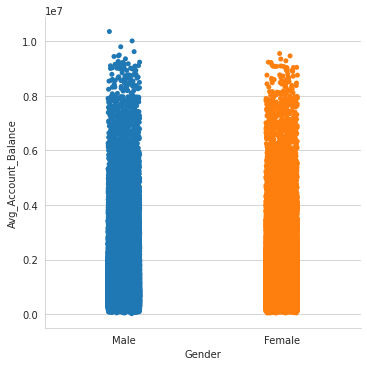

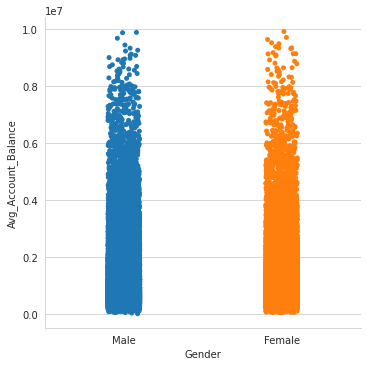

In [ ]:
sns.catplot(x="Gender", y="Avg_Account_Balance", data=df, order=["Male", "Female"])
sns.catplot(x="Gender", y="Avg_Account_Balance", data=dft, order=["Male", "Female"])

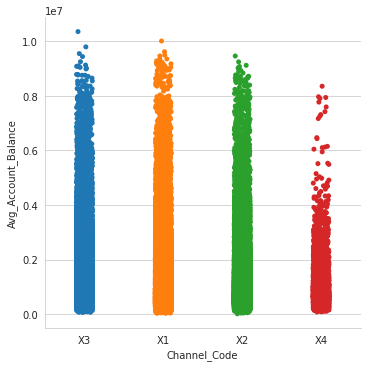

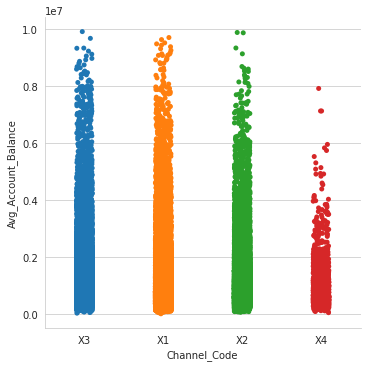

In [ ]:
sns.catplot(x="Channel_Code", y="Avg_Account_Balance", data=df, order=['X3', 'X1', 'X2', 'X4'])
sns.catplot(x="Channel_Code", y="Avg_Account_Balance", data=dft, order=['X3', 'X1', 'X2', 'X4'])

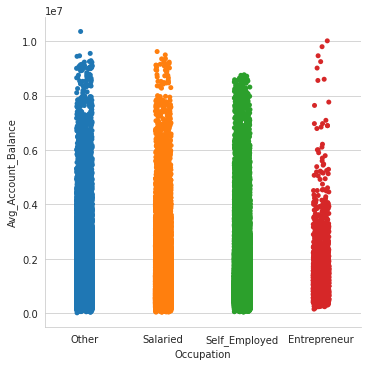

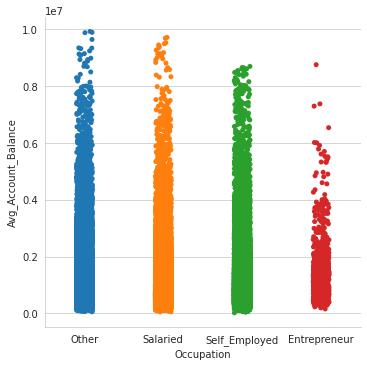

In [ ]:
sns.catplot(x="Occupation", y="Avg_Account_Balance", data=df, order=['Other', 'Salaried', 'Self_Employed', 'Entrepreneur'])
sns.catplot(x="Occupation", y="Avg_Account_Balance", data=dft, order=['Other', 'Salaried', 'Self_Employed', 'Entrepreneur'])

In [ ]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


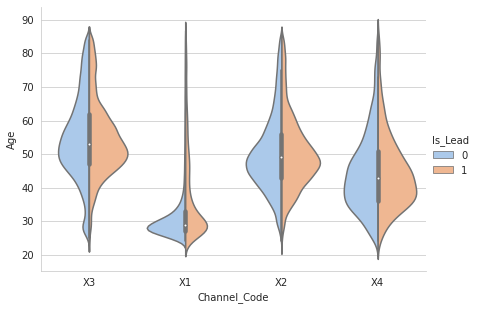

In [ ]:
ax = sns.catplot(x="Channel_Code", y="Age", hue="Is_Lead", kind="violin", split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

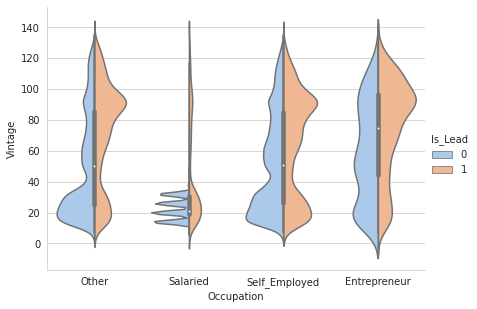

In [ ]:
ax = sns.catplot(x="Occupation", y="Vintage", hue="Is_Lead", kind="violin", split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

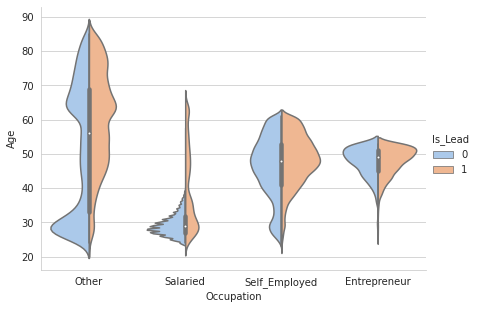

In [ ]:
ax = sns.catplot(x="Occupation", y="Age", hue="Is_Lead", kind="violin", split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

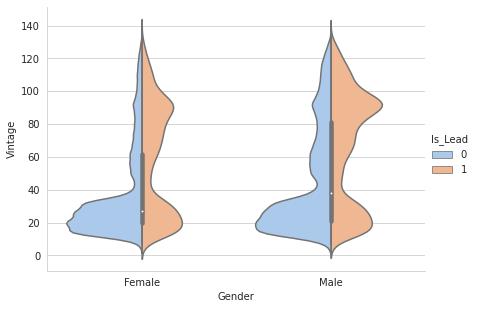

In [ ]:
ax = sns.catplot(x="Gender", y="Vintage", hue="Is_Lead", kind="violin", split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

##Missing Data Imputation

In [ ]:
train_knn = all_data[['Age','Vintage', 'Credit_Product', 'Avg_Account_Balance','Male',
                      'Entrepreneur', 'Salaried', 'Self_Employed', 'X2', 'X3', 'X4', 'Yesx']].copy(deep=True)

In [ ]:
train_knn.isnull().sum()

Age                        0
Vintage                    0
Credit_Product         41847
Avg_Account_Balance        0
Male                       0
Entrepreneur               0
Salaried                   0
Self_Employed              0
X2                         0
X3                         0
X4                         0
Yesx                       0
dtype: int64

In [ ]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
train_knn['Credit_Product'] = knn_imputer.fit_transform(train_knn[['Credit_Product']])
train_knn['Credit_Product'] = np.round(train_knn['Credit_Product'])
train_knn['Credit_Product'].unique()

In [ ]:
all_data[['Age','Vintage', 'Credit_Product', 'Avg_Account_Balance','Male','Entrepreneur', 
          'Salaried', 'Self_Employed', 'X2', 'X3', 'X4', 'Yesx']] = train_knn[['Age','Vintage', 'Credit_Product', 'Avg_Account_Balance','Male','Entrepreneur', 'Salaried', 'Self_Employed', 'X2', 'X3', 'X4', 'Yesx']]

# split the all-data DF into training and testing again
dfx = all_data[all_data['tst']==0]
dftx = all_data[all_data['tst']==1]

del all_data
gc.collect()

In [ ]:
dfx.to_csv("knn_jobathon_may_df.csv",index=False)
dftx.to_csv("knn_jobathon_may_dft.csv",index=False)

In [ ]:
!cp /content/knn_jobathon_may_df.csv '/content/drive/MyDrive/Colab Weights'
!cp /content/knn_jobathon_may_dft.csv '/content/drive/MyDrive/Colab Weights'

##Feature Engineering

In [ ]:
df.head(1)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0


In [ ]:
df = pd.read_csv("/content/train_s3TEQDk.csv")
dft = pd.read_csv("/content/test_mSzZ8RL.csv")
dfx = pd.read_csv("/content/drive/MyDrive/Colab Weights/knn_jobathon_may_df.csv")
dftx = pd.read_csv('/content/drive/MyDrive/Colab Weights/knn_jobathon_may_dft.csv')

dfx['Credit_Product'] = dfx['Credit_Product'].replace(to_replace =1.0,value ="Yesx")
dfx['Credit_Product'] = dfx['Credit_Product'].replace(to_replace =0.0,value ="Nox")
dftx['Credit_Product'] = dftx['Credit_Product'].replace(to_replace =1.0,value ="Yesx")
dftx['Credit_Product'] = dftx['Credit_Product'].replace(to_replace =0.0,value ="Nox")

df['Credit_Product'] = dfx['Credit_Product']
dft['Credit_Product'] = dftx['Credit_Product']

df = df.drop_duplicates()
df = df[~df.Region_Code.isin(list(set(df.Region_Code)-set(dft.Region_Code)))]

training_replica = df.copy()
testing_replica = dft.copy()

# set up a flag field to distinguish records from training and testing sets in the combined dataset
training_replica['tst'] = 0
testing_replica['tst'] = 1

# combine training and testing data into a single dataframe to do uniform part of feature engineering
all_data = pd.concat([training_replica, testing_replica], axis=0, copy=True)
del training_replica
del testing_replica
gc.collect()

print("Shape of datasets: ", df.shape, dft.shape, all_data.shape)

for col in ['Gender', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']:
  all_data['Region_'+str(col)] = all_data['Region_Code'].astype(str)+'_'+all_data[col].astype(str)

for col in ['Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']:
  all_data['Gender_'+str(col)] = all_data['Gender'].astype(str)+'_'+all_data[col].astype(str)

for col in ['Channel_Code','Credit_Product', 'Is_Active']:
  all_data['Occupation_'+str(col)] = all_data['Occupation'].astype(str)+'_'+all_data[col].astype(str)

for col in ['Credit_Product', 'Is_Active']:
  all_data['Channel_Code_'+str(col)] = all_data['Channel_Code'].astype(str)+'_'+all_data[col].astype(str)

for col in ['Is_Active']:
  all_data['Credit_Product_'+str(col)] = all_data['Credit_Product'].astype(str)+'_'+all_data[col].astype(str)

all_data['Region_Code'] = all_data['Region_Code'].str.replace("[^0-9]","")
all_data['Region_Code'] = all_data['Region_Code'].astype(float).astype(int)

all_data['Channel_Code'] = all_data['Channel_Code'].str.replace("[^0-9]","")
all_data['Channel_Code'] = all_data['Channel_Code'].astype(float).astype(int)

all_data = pd.get_dummies(all_data,columns=['Gender','Occupation','Credit_Product','Is_Active'],drop_first=True)

from sklearn.preprocessing import KBinsDiscretizer

account_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
all_data['Avg_Account_Balance_Bins'] =account_discretizer.fit_transform(all_data['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
all_data['Age_Bins'] =age_discretizer.fit_transform(all_data['Age'].values.reshape(-1,1)).astype(int)

vintage_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
all_data['Vintage_Bins'] =vintage_discretizer.fit_transform(all_data['Vintage'].values.reshape(-1,1)).astype(int)

for col in ['Age','Region_Code','Channel_Code']:
    val_counts = all_data[col].value_counts().to_dict()
    all_data[str(col)+"_counts"] = all_data[col].map(val_counts)

all_data.head(1)

Shape of datasets:  (245725, 11) (105312, 10) (351037, 12)


,ID,Age,Region_Code,Channel_Code,Vintage,Avg_Account_Balance,Is_Lead,tst,Region_Gender,Region_Occupation,Region_Channel_Code,Region_Credit_Product,Region_Is_Active,Gender_Occupation,Gender_Channel_Code,Gender_Credit_Product,Gender_Is_Active,Occupation_Channel_Code,Occupation_Credit_Product,Occupation_Is_Active,Channel_Code_Credit_Product,Channel_Code_Is_Active,Credit_Product_Is_Active,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yesx,Is_Active_Yes,Avg_Account_Balance_Bins,Age_Bins,Vintage_Bins,Age_counts,Region_Code_counts,Channel_Code_counts
0,NNVBBKZB,73,268,3,43,1045696,0.0,0,RG268_Female,RG268_Other,RG268_X3,RG268_Nox,RG268_No,Female_Other,Female_X3,Female_Nox,Female_No,Other_X3,Other_Nox,Other_No,X3_Nox,X3_No,Nox_No,0,1,0,0,0,0,4,9,5,1757,51059,97981


In [ ]:
all_data.nunique()

ID                             351037
Age                                63
Region_Code                        35
Channel_Code                        4
Vintage                            66
Avg_Account_Balance            162137
Is_Lead                             2
tst                                 2
Region_Gender                      70
Region_Occupation                 140
Region_Channel_Code               140
Region_Credit_Product              70
Region_Is_Active                   70
Gender_Occupation                   8
Gender_Channel_Code                 8
Gender_Credit_Product               4
Gender_Is_Active                    4
Occupation_Channel_Code            16
Occupation_Credit_Product           8
Occupation_Is_Active                8
Channel_Code_Credit_Product         8
Channel_Code_Is_Active              8
Credit_Product_Is_Active            4
Gender_Male                         2
Occupation_Other                    2
Occupation_Salaried                 2
Occupation_S

## CatBoost

In [ ]:
train_x_full = all_data[all_data['Is_Lead'].notnull()]
cols = ['Age', 'Region_Code','Channel_Code', 'Vintage','Avg_Account_Balance']

train_x_full = train_x_full[~train_x_full.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)
test_x_full = all_data[all_data['Is_Lead'].isnull()]
train_y_full = train_x_full['Is_Lead']
test_id=test_x_full['ID']
del test_x_full['Is_Lead']
del train_x_full['Is_Lead']
del test_x_full['ID']
del train_x_full['ID']
del test_x_full['tst']
del train_x_full['tst']
print(train_x_full.shape, train_y_full.shape, test_x_full.shape)

(245540, 32) (245540,) (105312, 32)


In [ ]:
for col in test_x_full.columns:
    print(col,":",len(set(train_x_full[col]).intersection(set(test_x_full[col]))))

Age : 62
Region_Code : 35
Channel_Code : 4
Vintage : 66
Avg_Account_Balance : 51470
Region_Gender : 70
Region_Occupation : 138
Region_Channel_Code : 140
Region_Credit_Product : 70
Region_Is_Active : 70
Gender_Occupation : 8
Gender_Channel_Code : 8
Gender_Credit_Product : 4
Gender_Is_Active : 4
Occupation_Channel_Code : 16
Occupation_Credit_Product : 8
Occupation_Is_Active : 8
Channel_Code_Credit_Product : 8
Channel_Code_Is_Active : 8
Credit_Product_Is_Active : 4
Gender_Male : 2
Occupation_Other : 2
Occupation_Salaried : 2
Occupation_Self_Employed : 2
Credit_Product_Yesx : 2
Is_Active_Yes : 2
Avg_Account_Balance_Bins : 8
Age_Bins : 10
Vintage_Bins : 10
Age_counts : 62
Region_Code_counts : 35
Channel_Code_counts : 4


In [ ]:
for col in ['Region_Code', 'Channel_Code','Gender_Male',
       'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
       'Credit_Product_Yesx', 'Is_Active_Yes', 'Avg_Account_Balance_Bins',
       'Age_Bins', 'Vintage_Bins']:
    train_x_full[col] = train_x_full[col].astype(int)
    test_x_full[col] = test_x_full[col].astype(int)

cat_features = ['Region_Code', 'Channel_Code',
       'Region_Gender', 'Region_Occupation', 'Region_Channel_Code',
       'Region_Credit_Product', 'Region_Is_Active', 'Gender_Occupation',
       'Gender_Channel_Code', 'Gender_Credit_Product', 'Gender_Is_Active',
       'Occupation_Channel_Code', 'Occupation_Credit_Product',
       'Occupation_Is_Active', 'Channel_Code_Credit_Product',
       'Channel_Code_Is_Active', 'Credit_Product_Is_Active', 'Gender_Male',
       'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
       'Credit_Product_Yesx', 'Is_Active_Yes', 'Avg_Account_Balance_Bins',
       'Age_Bins', 'Vintage_Bins']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold, GroupKFold,train_test_split

In [ ]:
train_x = train_x_full.copy()
train_y = train_y_full.copy()
test_x = test_x_full.copy()
feature_importance_df = pd.DataFrame()

NFOLDS = 2
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=1)
pred_test = []
pred_x = []
pred_y = []
j=1

In [ ]:
for fold, (train_ids, test_ids) in enumerate(folds.split(train_x, train_y)):
    print('● Fold :', fold+1)
    model = CatBoostClassifier(n_estimators=20000, random_state=1, learning_rate=0.03, eval_metric='AUC', cat_features =cat_features)
    model.fit(train_x.loc[train_ids], train_y.loc[train_ids], 
              eval_set=[(train_x.loc[train_ids], train_y.loc[train_ids]), (train_x.loc[test_ids], train_y.loc[test_ids])],
              verbose=500, early_stopping_rounds=200)
    pred_fold = model.predict_proba(train_x.loc[test_ids])[:,-1]
    pred_x.extend([float(i) for i  in pred_fold])
    pred_y.extend(list(train_y.loc[test_ids].values))
    pred_fold_test = model.predict_proba(test_x)[:,-1]
    pred_test.append([float(i) for i  in pred_fold_test])
    print('\n')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_x.loc[train_ids].columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = j + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    j=j+1

● Fold : 1
0:	test: 0.7569204	test1: 0.7571777	best: 0.7571777 (0)	total: 1.16s	remaining: 6h 25m 29s
500:	test: 0.7928848	test1: 0.7888200	best: 0.7888200 (500)	total: 6m 21s	remaining: 4h 7m 41s
1000:	test: 0.7963642	test1: 0.7896106	best: 0.7896205 (982)	total: 12m 55s	remaining: 4h 5m 19s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7897307311
bestIteration = 1277

Shrink model to first 1278 iterations.


● Fold : 2
0:	test: 0.7575413	test1: 0.7564967	best: 0.7564967 (0)	total: 1.02s	remaining: 5h 41m 16s
500:	test: 0.7936466	test1: 0.7871291	best: 0.7871291 (500)	total: 6m 22s	remaining: 4h 7m 58s
1000:	test: 0.7964257	test1: 0.7879108	best: 0.7879112 (999)	total: 12m 56s	remaining: 4h 5m 33s
1500:	test: 0.7983023	test1: 0.7882675	best: 0.7882798 (1490)	total: 19m 33s	remaining: 4h 1m 5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7884042123
bestIteration = 1780

Shrink model to first 1781 iterations.




In [ ]:
from sklearn.metrics import f1_score,classification_report, roc_auc_score
print("Final ROC-AUC Score:", roc_auc_score(pred_y, pred_x))

final_prediction = pd.DataFrame(pred_test).T
final_prediction.columns = [("FOLD_"+str(i)) for i in range(final_prediction.shape[1])]

vote = final_prediction.mean(axis=1)
final_prediction['Is_Lead'] = vote
final_prediction['ID'] = test_id.values
print(final_prediction.shape)

#train_pred_all['cb_pred'] = pred_x
final_prediction_cb = final_prediction.copy()

final_prediction.head()

Final ROC-AUC Score: 0.7890193988365253
(105312, 4)


,FOLD_0,FOLD_1,Is_Lead,ID
0,0.051040,0.042109,0.046574,VBENBARO
1,0.248216,0.219780,0.233998,CCMEWNKY
2,0.074925,0.062272,0.068598,VK3KGA9M
3,0.034800,0.033643,0.034222,TT8RPZVC
4,0.028511,0.028076,0.028294,SHQZEYTZ


In [ ]:
df_submission = final_prediction[['ID', 'Is_Lead']]
df_submission.to_csv("cb_v4.csv", index = False)
df_submission.head()

,ID,Is_Lead
0,VBENBARO,0.046574
1,CCMEWNKY,0.233998
2,VK3KGA9M,0.068598
3,TT8RPZVC,0.034222
4,SHQZEYTZ,0.028294


In [ ]:
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[all_features['importance']!=0]['feature'])
all_features

,feature,importance
0,Occupation_Channel_Code,14.198669
1,Vintage,9.865427
2,Age_Bins,9.488143
3,Vintage_Bins,8.450913
4,Age,8.089288
5,Credit_Product_Is_Active,5.805406
6,Occupation_Salaried,4.224937
7,Occupation_Is_Active,3.564495
8,Age_counts,3.405972
9,Occupation_Credit_Product,3.367355


## Modelling

In [ ]:
# split the all-data DF into training and testing again
dfpy = all_data[all_data['tst']==0]
dftpy = all_data[all_data['tst']==1]

In [ ]:
dfpy.head(2)

,ID,Age,Region_Code,Channel_Code,Vintage,Avg_Account_Balance,Is_Lead,tst,Region_Gender,Region_Occupation,Region_Channel_Code,Region_Credit_Product,Region_Is_Active,Gender_Occupation,Gender_Channel_Code,Gender_Credit_Product,Gender_Is_Active,Occupation_Channel_Code,Occupation_Credit_Product,Occupation_Is_Active,Channel_Code_Credit_Product,Channel_Code_Is_Active,Credit_Product_Is_Active,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yesx,Is_Active_Yes,Avg_Account_Balance_Bins,Age_Bins,Vintage_Bins,Age_counts,Region_Code_counts,Channel_Code_counts
0,NNVBBKZB,73,268,3,43,1045696,0.0,0,RG268_Female,RG268_Other,RG268_X3,RG268_Nox,RG268_No,Female_Other,Female_X3,Female_Nox,Female_No,Other_X3,Other_Nox,Other_No,X3_Nox,X3_No,Nox_No,0,1,0,0,0,0,4,9,5,1757,51059,97981
1,IDD62UNG,30,277,1,32,581988,0.0,0,RG277_Female,RG277_Salaried,RG277_X1,RG277_Nox,RG277_No,Female_Salaried,Female_X1,Female_Nox,Female_No,Salaried_X1,Salaried_Nox,Salaried_No,X1_Nox,X1_No,Nox_No,0,0,1,0,0,0,1,2,5,15684,18422,148202


In [ ]:
from pycaret.classification import *
exp_clf = setup(dfpy,
                target='Is_Lead',
                use_gpu = False,
                #numeric_imputation = 'mean', #median
                #categorical_imputation = 'mode', #constant
                #numeric_features = [],
                #categorical_features = ['8'],
                #date_features = [],
                ignore_features = ['ID'],
                #ordinal_features = {'column_name' : [‘low’, ‘medium’, ‘high’] },
                #high_cardinality_features = ['Region_Code'],
                #high_cardinality_method = 'frequency', #clustering,
                #group_features = [],
                #handle_unknown_categorical = True,
                #unknown_categorical_method = 'least_frequent', or 'most_frequent',
                #combine_rare_levels = True,
                #bin_numeric_features = ['0','1'],
                #transformation = True,
                #transformation_method = 'yeo-johnson',#'quantile',yeo-johnson,
                #transform_target = True,
                #transform_target_method = 'yeo-johnson', #box-cox
                #feature_selection = True,
                normalize = True,
                normalize_method = 'zscore',#minmax ,maxabs ,robust, zscore,
                #fix_imbalance = True,
                #pca = True,
                #pca_method = 'incremental', #kernel, incremental, linear
                #feature_interaction = True,
                #feature_ratio = True,
                #trigonometry_features=True,
                #polynomial_features = True,
                #log_experiment = True,
                #experiment_name = 'amzn1'
                )

,Description,Value
0,session_id,1453
1,Target,Is_Lead
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(245725, 35)"
5,Missing Values,False
6,Numeric Features,12
7,Categorical Features,21
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(sort = 'AUC')

IntProgress(value=0, description='Processing: ', max=79)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:05:23
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Discriminant Analysis


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


In [ ]:
compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7930,0.7874,0.2551,0.6677,0.3691,0.2738,0.3193,1.585
catboost,CatBoost Classifier,0.7929,0.7855,0.2819,0.6467,0.3926,0.2903,0.3268,70.981
xgboost,Extreme Gradient Boosting,0.7922,0.7834,0.2757,0.6466,0.3865,0.2850,0.3227,19.113
gbc,Gradient Boosting Classifier,0.7917,0.7808,0.2125,0.7026,0.3262,0.2428,0.3040,15.883
ada,Ada Boost Classifier,0.7822,0.7604,0.1873,0.6419,0.2899,0.2046,0.2593,4.193
rf,Random Forest Classifier,0.7789,0.7542,0.3106,0.5621,0.4001,0.2782,0.2966,19.144
et,Extra Trees Classifier,0.7677,0.7397,0.3217,0.5174,0.3967,0.2624,0.2738,17.180
lda,Linear Discriminant Analysis,0.7700,0.7331,0.1376,0.5637,0.2212,0.1412,0.1902,0.408
nb,Naive Bayes,0.7521,0.6793,0.0726,0.3834,0.1220,0.0502,0.0744,0.136
dt,Decision Tree Classifier,0.7090,0.6077,0.4149,0.3930,0.4036,0.2113,0.2115,1.126


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=682, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#making catboost
catboost = create_model('catboost')
predict_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7936,0.7843,0.2806,0.6465,0.3913,0.2896,0.3263
1,0.7927,0.7789,0.2825,0.6398,0.3919,0.2889,0.3241
2,0.7937,0.7865,0.2847,0.6440,0.3949,0.2923,0.3278
3,0.7952,0.7925,0.2776,0.6591,0.3907,0.2913,0.3308
4,0.7959,0.7874,0.2786,0.6626,0.3922,0.2933,0.3332
5,0.7913,0.7828,0.2702,0.6390,0.3798,0.2784,0.3158
6,0.7941,0.7911,0.2863,0.6456,0.3967,0.2941,0.3296
7,0.7934,0.7863,0.2838,0.6425,0.3937,0.2910,0.3264
8,0.7911,0.7857,0.2730,0.6354,0.3819,0.2795,0.3157
9,0.7953,0.7920,0.2865,0.6530,0.3983,0.2969,0.3336


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7919,0.7876,0.2816,0.649,0.3927,0.29,0.327


,Age,Region_Code,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yesx,Is_Active_Yes,Age_counts,Region_Code_counts,Channel_Code_2,tst_0,Region_Gender_RG250_Female,Region_Gender_RG250_Male,Region_Gender_RG251_Female,Region_Gender_RG251_Male,Region_Gender_RG252_Female,Region_Gender_RG252_Male,Region_Gender_RG253_Female,Region_Gender_RG253_Male,Region_Gender_RG254_Female,Region_Gender_RG254_Male,Region_Gender_RG255_Female,Region_Gender_RG255_Male,Region_Gender_RG256_Female,Region_Gender_RG256_Male,Region_Gender_RG257_Female,Region_Gender_RG257_Male,Region_Gender_RG258_Female,Region_Gender_RG258_Male,Region_Gender_RG259_Female,Region_Gender_RG259_Male,Region_Gender_RG260_Female,Region_Gender_RG260_Male,Region_Gender_RG261_Female,Region_Gender_RG261_Male,Region_Gender_RG262_Female,Region_Gender_RG262_Male,...,Channel_Code_Is_Active_X4_No,Channel_Code_Is_Active_X4_Yes,Credit_Product_Is_Active_Nox_No,Credit_Product_Is_Active_Nox_Yes,Credit_Product_Is_Active_Yesx_No,Credit_Product_Is_Active_Yesx_Yes,Avg_Account_Balance_Bins_0,Avg_Account_Balance_Bins_1,Avg_Account_Balance_Bins_2,Avg_Account_Balance_Bins_3,Avg_Account_Balance_Bins_4,Avg_Account_Balance_Bins_5,Avg_Account_Balance_Bins_6,Avg_Account_Balance_Bins_7,Age_Bins_0,Age_Bins_1,Age_Bins_2,Age_Bins_3,Age_Bins_4,Age_Bins_5,Age_Bins_6,Age_Bins_7,Age_Bins_8,Age_Bins_9,Vintage_Bins_0,Vintage_Bins_1,Vintage_Bins_2,Vintage_Bins_3,Vintage_Bins_4,Vintage_Bins_5,Vintage_Bins_6,Vintage_Bins_7,Vintage_Bins_8,Vintage_Bins_9,Channel_Code_counts_148202,Channel_Code_counts_7952,Channel_Code_counts_97981,Is_Lead,Label,Score
0,-1.337622,-1.552364,-1.048539,-0.240400,0,0,1,0,0,1,-1.153715,-1.204619,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.9697
1,-1.135294,-0.816356,-0.986733,-0.031774,0,0,1,0,0,0,1.675793,-0.734987,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.9263
2,-1.135294,0.471657,-1.017636,-0.281415,1,0,1,0,1,0,1.675793,-1.093059,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.9122
3,0.685666,1.207665,-1.048539,-0.664053,0,0,0,1,0,0,-0.400612,1.050993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.5176
4,0.146122,0.655659,-1.048539,-0.694642,1,0,0,1,1,0,-0.163192,-0.307929,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.8350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73713,-1.000408,-1.460363,-0.677703,-0.525889,1,0,1,0,0,1,1.741319,0.839257,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [ ]:
#traing on the whole dataset
finalize_model(catboost)
#predictiing on test data
del dftpy['Is_Lead']
test_predictions = predict_model(catboost, data=dftpy)
#storing the predictions in another dataframe and converting the dataframe to a csv file.
test_predictions.rename(columns = {'Label':'Is_Lead'}, inplace = True)
subx = test_predictions[['ID','Is_Lead']]
subx.to_csv("sub_tuned_catboost1.csv",index=False)

KeyError: ignored

In [ ]:
test_predictions = predict_model(catboost, data=dftpy)
#storing the predictions in another dataframe and converting the dataframe to a csv file.
test_predictions.rename(columns = {'Label':'Is_Lead'}, inplace = True)
subx = test_predictions[['ID','Is_Lead']]
subx.to_csv("sub_tuned_catboost1.csv",index=False)

In [ ]:
#making lightgbm
lightgbm = create_model('lightgbm')
predict_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7929,0.7852,0.2503,0.6649,0.3637,0.2692,0.3152
1,0.7925,0.7793,0.2545,0.6580,0.3670,0.2709,0.3148
2,0.7925,0.7876,0.2545,0.6580,0.3670,0.2709,0.3148
3,0.7953,0.7939,0.2579,0.6759,0.3734,0.2792,0.3257
4,0.7943,0.7891,0.2565,0.6699,0.3709,0.2761,0.3218
5,0.7928,0.7845,0.2530,0.6617,0.3661,0.2707,0.3156
6,0.7957,0.7934,0.2644,0.6723,0.3795,0.2840,0.3285
7,0.7958,0.7878,0.2619,0.6758,0.3775,0.2828,0.3284
8,0.7884,0.7886,0.2440,0.6367,0.3528,0.2552,0.2974
9,0.7952,0.7947,0.2654,0.6685,0.3799,0.2837,0.3273


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7933,0.7894,0.2608,0.675,0.3762,0.2804,0.3261


,Age,Region_Code,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yesx,Is_Active_Yes,Age_counts,Region_Code_counts,Channel_Code_2,tst_0,Region_Gender_RG250_Female,Region_Gender_RG250_Male,Region_Gender_RG251_Female,Region_Gender_RG251_Male,Region_Gender_RG252_Female,Region_Gender_RG252_Male,Region_Gender_RG253_Female,Region_Gender_RG253_Male,Region_Gender_RG254_Female,Region_Gender_RG254_Male,Region_Gender_RG255_Female,Region_Gender_RG255_Male,Region_Gender_RG256_Female,Region_Gender_RG256_Male,Region_Gender_RG257_Female,Region_Gender_RG257_Male,Region_Gender_RG258_Female,Region_Gender_RG258_Male,Region_Gender_RG259_Female,Region_Gender_RG259_Male,Region_Gender_RG260_Female,Region_Gender_RG260_Male,Region_Gender_RG261_Female,Region_Gender_RG261_Male,Region_Gender_RG262_Female,Region_Gender_RG262_Male,...,Channel_Code_Is_Active_X4_No,Channel_Code_Is_Active_X4_Yes,Credit_Product_Is_Active_Nox_No,Credit_Product_Is_Active_Nox_Yes,Credit_Product_Is_Active_Yesx_No,Credit_Product_Is_Active_Yesx_Yes,Avg_Account_Balance_Bins_0,Avg_Account_Balance_Bins_1,Avg_Account_Balance_Bins_2,Avg_Account_Balance_Bins_3,Avg_Account_Balance_Bins_4,Avg_Account_Balance_Bins_5,Avg_Account_Balance_Bins_6,Avg_Account_Balance_Bins_7,Age_Bins_0,Age_Bins_1,Age_Bins_2,Age_Bins_3,Age_Bins_4,Age_Bins_5,Age_Bins_6,Age_Bins_7,Age_Bins_8,Age_Bins_9,Vintage_Bins_0,Vintage_Bins_1,Vintage_Bins_2,Vintage_Bins_3,Vintage_Bins_4,Vintage_Bins_5,Vintage_Bins_6,Vintage_Bins_7,Vintage_Bins_8,Vintage_Bins_9,Channel_Code_counts_148202,Channel_Code_counts_7952,Channel_Code_counts_97981,Is_Lead,Label,Score
0,-1.337622,-1.552364,-1.048539,-0.240400,0,0,1,0,0,1,-1.153715,-1.204619,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.9531
1,-1.135294,-0.816356,-0.986733,-0.031774,0,0,1,0,0,0,1.675793,-0.734987,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.9338
2,-1.135294,0.471657,-1.017636,-0.281415,1,0,1,0,1,0,1.675793,-1.093059,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.8959
3,0.685666,1.207665,-1.048539,-0.664053,0,0,0,1,0,0,-0.400612,1.050993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.5556
4,0.146122,0.655659,-1.048539,-0.694642,1,0,0,1,1,0,-0.163192,-0.307929,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.7774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73713,-1.000408,-1.460363,-0.677703,-0.525889,1,0,1,0,0,1,1.741319,0.839257,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [ ]:
#making lightgbm
lightgbm = create_model('lightgbm')
predict_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7904,0.7856,0.2488,0.6538,0.3605,0.2642,0.3084
1,0.7934,0.7861,0.2523,0.6728,0.3669,0.2728,0.3199
2,0.7915,0.7843,0.2638,0.6496,0.3752,0.2759,0.3164
3,0.7929,0.7892,0.2622,0.6607,0.3755,0.2781,0.3209
4,0.7953,0.7876,0.2524,0.6878,0.3693,0.2772,0.3270
5,0.7911,0.7897,0.2544,0.6547,0.3664,0.2693,0.3126
6,0.7943,0.7913,0.2640,0.6691,0.3786,0.2822,0.3262
7,0.7925,0.7849,0.2488,0.6693,0.3628,0.2687,0.3158
8,0.7937,0.7879,0.2564,0.6712,0.3711,0.2761,0.3220
9,0.7948,0.7878,0.2481,0.6877,0.3647,0.2732,0.3239


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7951,0.7918,0.2536,0.6805,0.3695,0.2765,0.3247


,Age,Region_Code,Vintage,Avg_Account_Balance,Credit_Product_1.0,Male_0,Entrepreneur_0,Salaried_1,Self_Employed_0,X2_0,X3_0,X4_0,Yesx_1,tst_0,Is_Lead,Label,Score
0,48.0,13548.0,91.0,1220101.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.6171
1,36.0,5399.0,20.0,755227.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.7053
2,42.0,18669.0,27.0,859312.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.7190
3,27.0,18669.0,25.0,2251148.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.9388
4,68.0,18669.0,57.0,1236405.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.8817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73713,41.0,8959.0,49.0,701177.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.8404
73714,44.0,25342.0,37.0,1341657.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.7952
73715,29.0,18669.0,25.0,1058459.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.9263
73716,59.0,4051.0,69.0,810451.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.6106


In [ ]:
#traing on the whole dataset
finalize_model(lightgbm)
#predictiing on test data
del dftpy['Is_Lead']
test_predictions = predict_model(lightgbm, data=dftpy)
#storing the predictions in another dataframe and converting the dataframe to a csv file.
test_predictions.rename(columns = {'Label':'Is_Lead'}, inplace = True)
subx = test_predictions[['ID','Is_Lead']]
subx.to_csv("sub_tuned_lgbm1.csv",index=False)

#Method 3

In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_eyYijxG.csv
!pip install catboost

--2021-05-30 13:55:31--  https://datahack-prod.s3.amazonaws.com/train_file/train_s3TEQDk.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.72
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13782835 (13M) [text/csv]
Saving to: ‘train_s3TEQDk.csv’

train_s3TEQDk.csv   100%[===================>]  13.14M  4.94MB/s    in 2.7s    

2021-05-30 13:55:35 (4.94 MB/s) - ‘train_s3TEQDk.csv’ saved [13782835/13782835]

--2021-05-30 13:55:35--  https://datahack-prod.s3.amazonaws.com/test_file/test_mSzZ8RL.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.112
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5696419 (5.4M) [text/csv]
Saving to: ‘test_mSzZ8RL.csv’

test_mSzZ8RL.csv    100%[==

In [ ]:
# import required packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score

import gc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
# read train and test data
train = pd.read_csv("/content/train_s3TEQDk.csv")
test = pd.read_csv("/content/test_mSzZ8RL.csv")
dfx = pd.read_csv("/content/drive/MyDrive/Colab Weights/knn_jobathon_may_df.csv")
dftx = pd.read_csv('/content/drive/MyDrive/Colab Weights/knn_jobathon_may_dft.csv')
dfx['Credit_Product'] = dfx['Credit_Product'].replace(to_replace =1.0,value ="Yesx")
dfx['Credit_Product'] = dfx['Credit_Product'].replace(to_replace =0.0,value ="Nox")
dftx['Credit_Product'] = dftx['Credit_Product'].replace(to_replace =1.0,value ="Yesx")
dftx['Credit_Product'] = dftx['Credit_Product'].replace(to_replace =0.0,value ="Nox")
train['Credit_Product'] = dfx['Credit_Product']
test['Credit_Product'] = dftx['Credit_Product']
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,Nox,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,Nox,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,Nox,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,Nox,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,Nox,886787,No,0


In [ ]:
# As most of the features are categorical, check if test data has all categorical values same as train data.
# If any column has new values then we should be careful using that feature in training directly..
count=0
for col in train.columns:
    if col not in ['ID','Age','Vintage','Avg_Account_Balance','Is_Lead']:
        for val in test[col].unique():
            if val not in train[col].unique():
                print(col,val)
                count+=1

In [ ]:
# join both train and test data for preprocessing..
train['train'] = 1
test['train'] = 0

df = pd.concat([train,test],axis=0).reset_index(drop=True)

In [ ]:
train.drop(124356, axis=0, inplace=True)
train.drop(138374, axis=0, inplace=True)

In [ ]:
train[train['Avg_Account_Balance']>10000000]

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train


In [ ]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead,train
count,245723.000000,245723.000000,2.457230e+05,245723.000000,245723.0
mean,43.856220,46.958807,1.128329e+06,0.237206,1.0
std,14.828671,32.353000,8.525487e+05,0.425371,0.0
min,23.000000,7.000000,2.079000e+04,0.000000,1.0
25%,30.000000,20.000000,6.043100e+05,0.000000,1.0
50%,43.000000,32.000000,8.945920e+05,0.000000,1.0
75%,54.000000,73.000000,1.366648e+06,0.000000,1.0
max,85.000000,135.000000,9.792796e+06,1.000000,1.0


In [ ]:
test.describe()

,Age,Vintage,Avg_Account_Balance,train
count,105312.000000,105312.000000,1.053120e+05,105312.0
mean,43.871002,46.842819,1.134195e+06,0.0
std,14.872890,32.273634,8.662430e+05,0.0
min,24.000000,7.000000,2.259700e+04,0.0
25%,30.000000,20.000000,6.039822e+05,0.0
50%,43.000000,32.000000,8.966345e+05,0.0
75%,54.000000,73.000000,1.371598e+06,0.0
max,85.000000,135.000000,9.908858e+06,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351037 entries, 0 to 351036
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   351037 non-null  object 
 1   Gender               351037 non-null  object 
 2   Age                  351037 non-null  int64  
 3   Region_Code          351037 non-null  object 
 4   Occupation           351037 non-null  object 
 5   Channel_Code         351037 non-null  object 
 6   Vintage              351037 non-null  int64  
 7   Credit_Product       351037 non-null  object 
 8   Avg_Account_Balance  351037 non-null  int64  
 9   Is_Active            351037 non-null  object 
 10  Is_Lead              245725 non-null  float64
 11  train                351037 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 32.1+ MB


In [ ]:
# save the list of categorical coumns for future use..
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
categorical_columns

['ID']

In [ ]:
def label_encoder_exclude_nan(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    categorical_columns.remove('ID')
    print(categorical_columns)
    for feat in categorical_columns:
        le = LabelEncoder()
        fit_by = pd.Series([i for i in df[feat].unique() if type(i) == str])
        le.fit(fit_by)
        ### Set transformed col leaving np.NaN as they are
        df[feat] = df[feat].map(lambda x: le.transform([x])[0] if type(x) == str else x)
    print('Label encoding complete.')
    return df
df = label_encoder_exclude_nan(df)

['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
Label encoding complete.


In [ ]:
# Let's normalize the Premium feature and see if it helps model to learn better. Results show it's helping the model..
df['Avg_Account_Balance_normalized'] = np.log1p(df['Avg_Account_Balance'])

In [ ]:
# Let's do some binning of continuous columns..
df['Age_bin'] =  pd.qcut(df['Age'], 10).astype('object').astype(str)
df['Vintage_bin'] =  pd.qcut(df['Vintage'], 5).astype('object').astype(str)
df['Avg_Account_Balance_bin'] =  pd.qcut(df['Avg_Account_Balance'], 10).astype('object').astype(str)

In [ ]:
df = label_encoder_exclude_nan(df)

['Age_bin', 'Vintage_bin', 'Avg_Account_Balance_bin']
Label encoding complete.


In [ ]:
# Create feature using count of each value, it will help to find most popular and least popular category in each feature
def encode_FE(df,col):
    cv = df[col].value_counts()
    nm = str(col)+'_FE'
    df[nm] = df[col].map(cv)

feats = [f for f in df.columns if f not in ['ID','train','Is_Lead', 'Avg_Account_Balance','Avg_Account_Balance_normalized']]
for col in feats:
    encode_FE(df,col)

In [ ]:
# Take premium price to lower age and age diff ratio. Hypothesis is as age increases the premium price increases.
# It will help the model to know if any customer is being charged heavily for same age. If yes, there is less chance he will buy
df['aab_vs_age'] = df['Avg_Account_Balance']/df['Age']
df['aab_vs_vintage'] = df['Avg_Account_Balance']/df['Vintage']


In [ ]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train,Avg_Account_Balance_normalized,Age_bin,Vintage_bin,Avg_Account_Balance_bin,Gender_FE,Age_FE,Region_Code_FE,Occupation_FE,Channel_Code_FE,Vintage_FE,Credit_Product_FE,Is_Active_FE,Age_bin_FE,Vintage_bin_FE,Avg_Account_Balance_bin_FE,aab_vs_age,aab_vs_vintage
0,NNVBBKZB,0,73,18,1,2,43,0,1045696,0,0.0,1,13.860194,9,1,9,159135,1757,51059,100304,97981,2297,247812,214087,35076,57789,35102,14324.602740,24318.511628
1,IDD62UNG,0,30,27,2,0,32,0,581988,0,0.0,1,13.274207,2,1,6,159135,15684,18422,102912,148202,13600,247812,214087,27662,57789,35103,19399.600000,18187.125000
2,HD3DSEMC,0,56,18,3,2,26,0,1484315,1,0.0,1,14.210465,7,0,1,159135,5988,51059,144078,97981,15707,247812,136950,34591,81343,35103,26505.625000,57089.038462
3,BF3NC7KV,1,34,20,2,0,19,0,470454,0,0.0,1,13.061456,3,3,5,191902,6165,11160,102912,148202,17457,247812,214087,32579,73029,35104,13836.882353,24760.736842
4,TEASRWXV,0,30,32,2,0,33,0,886787,0,0.0,1,13.695361,2,1,8,159135,15684,8166,102912,148202,13661,247812,214087,27662,57789,35104,29559.566667,26872.333333


In [ ]:
# Find top 10 largest values and take it's sum.
def top_10_sum(x):
    return x.nlargest(10).sum()

# Find bottom 10 smallest values and take it's sum.
def bottom_10_sum(x):
    return x.nsmallest(10).sum()

# function to calculate mode..
def calc_mode(x):
    return pd.Series.mode(x)[0]

In [ ]:
AGGREGATION_RECIPIES = [(['Region_Code','Occupation'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                            ('Avg_Account_Balance', 'max'),
                            ('Avg_Account_Balance', 'std'),
                            ('Avg_Account_Balance', 'skew'),
                            ('Avg_Account_Balance', top_10_sum),
                            ('Avg_Account_Balance', bottom_10_sum)
                         ]
                        ),
                        (['Region_Code','Channel_Code'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                            ('Avg_Account_Balance', 'max'),
                            ('Avg_Account_Balance', 'std'),
                            ('Avg_Account_Balance', 'skew'),
                            ('Avg_Account_Balance', top_10_sum),
                            ('Avg_Account_Balance', bottom_10_sum)
                         ]
                        ),
                        (['Region_Code'], 
                         [
                            ('Avg_Account_Balance', 'count'),
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                            ('Avg_Account_Balance', 'max'),
                            ('Avg_Account_Balance', 'std'),
                            ('Avg_Account_Balance', 'skew'),
                            ('Avg_Account_Balance', calc_mode)
                         ]
                        ),
                        (['Occupation','Channel_Code'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                            ('Avg_Account_Balance', 'max'),
                            ('Avg_Account_Balance', 'std'),
                         ]
                        ),
                        (['Occupation'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                            ('Avg_Account_Balance', 'max'),
                            ('Avg_Account_Balance', 'std'),
                            ('Avg_Account_Balance', 'skew')
                         ]
                        ),
]

groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = df.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


In [ ]:
df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,train,Avg_Account_Balance_normalized,Age_bin,Vintage_bin,Avg_Account_Balance_bin,Gender_FE,Age_FE,Region_Code_FE,Occupation_FE,Channel_Code_FE,Vintage_FE,Credit_Product_FE,Is_Active_FE,Age_bin_FE,Vintage_bin_FE,Avg_Account_Balance_bin_FE,aab_vs_age,aab_vs_vintage,Region_Code_Occupation_min_Avg_Account_Balance_x,Region_Code_Occupation_mean_Avg_Account_Balance_x,Region_Code_Occupation_max_Avg_Account_Balance_x,Region_Code_Occupation_std_Avg_Account_Balance_x,Region_Code_Occupation_skew_Avg_Account_Balance_x,Region_Code_Occupation_<function top_10_sum at 0x7f6c5c8477a0>_Avg_Account_Balance_x,Region_Code_Occupation_<function bottom_10_sum at 0x7f6c5c847cb0>_Avg_Account_Balance_x,Region_Code_Channel_Code_min_Avg_Account_Balance_x,Region_Code_Channel_Code_mean_Avg_Account_Balance_x,Region_Code_Channel_Code_max_Avg_Account_Balance_x,Region_Code_Channel_Code_std_Avg_Account_Balance_x,Region_Code_Channel_Code_skew_Avg_Account_Balance_x,Region_Code_Channel_Code_<function top_10_sum at 0x7f6c5c8477a0>_Avg_Account_Balance_x,Region_Code_Channel_Code_<function bottom_10_sum at 0x7f6c5c847cb0>_Avg_Account_Balance_x,Region_Code_count_Avg_Account_Balance_x,Region_Code_min_Avg_Account_Balance_x,Region_Code_mean_Avg_Account_Balance_x,Region_Code_max_Avg_Account_Balance_x,Region_Code_std_Avg_Account_Balance_x,Region_Code_skew_Avg_Account_Balance_x,Region_Code_<function calc_mode at 0x7f6c5c8474d0>_Avg_Account_Balance_x,Occupation_Channel_Code_min_Avg_Account_Balance_x,Occupation_Channel_Code_mean_Avg_Account_Balance_x,Occupation_Channel_Code_max_Avg_Account_Balance_x,Occupation_Channel_Code_std_Avg_Account_Balance_x,Region_Code_Occupation_min_Avg_Account_Balance_y,Region_Code_Occupation_mean_Avg_Account_Balance_y,Region_Code_Occupation_max_Avg_Account_Balance_y,Region_Code_Occupation_std_Avg_Account_Balance_y,Region_Code_Occupation_skew_Avg_Account_Balance_y,Region_Code_Occupation_<function top_10_sum at 0x7f6c5c8477a0>_Avg_Account_Balance_y,Region_Code_Occupation_<function bottom_10_sum at 0x7f6c5c847cb0>_Avg_Account_Balance_y,Region_Code_Channel_Code_min_Avg_Account_Balance_y,Region_Code_Channel_Code_mean_Avg_Account_Balance_y,Region_Code_Channel_Code_max_Avg_Account_Balance_y,Region_Code_Channel_Code_std_Avg_Account_Balance_y,Region_Code_Channel_Code_skew_Avg_Account_Balance_y,Region_Code_Channel_Code_<function top_10_sum at 0x7f6c5c8477a0>_Avg_Account_Balance_y,Region_Code_Channel_Code_<function bottom_10_sum at 0x7f6c5c847cb0>_Avg_Account_Balance_y,Region_Code_count_Avg_Account_Balance_y,Region_Code_min_Avg_Account_Balance_y,Region_Code_mean_Avg_Account_Balance_y,Region_Code_max_Avg_Account_Balance_y,Region_Code_std_Avg_Account_Balance_y,Region_Code_skew_Avg_Account_Balance_y,Region_Code_<function calc_mode at 0x7f6c5c8474d0>_Avg_Account_Balance_y,Occupation_Channel_Code_min_Avg_Account_Balance_y,Occupation_Channel_Code_mean_Avg_Account_Balance_y,Occupation_Channel_Code_max_Avg_Account_Balance_y,Occupation_Channel_Code_std_Avg_Account_Balance_y,Occupation_min_Avg_Account_Balance,Occupation_mean_Avg_Account_Balance,Occupation_max_Avg_Account_Balance,Occupation_std_Avg_Account_Balance,Occupation_skew_Avg_Account_Balance
0,NNVBBKZB,0,73,18,1,2,43,0,1045696,0,0.0,1,13.860194,9,1,9,159135,1757,51059,100304,97981,2297,247812,214087,35076,57789,35102,14324.602740,24318.511628,45950,1.540149e+06,10352009,1.045607e+06,2.268540,93952961,1922271,161739,1.513277e+06,10352009,1.006668e+06,2.350544,91714382,1928966,51059,45950,1.471135e+06,10352009,1.015912e+06,2.452990,4022185,66812,1.347985e+06,10352009,978103.651680,45950,1.540149e+06,10352009,1.045607e+06,2.268540,93952961,1922271,161739,1.513277e+06,10352009,1.006668e+06,2.350544,91714382,1928966,51059,45950,1.471135e+06,10352009,1.015912e+06,2.452990,4022185,66812,1.347985e+06,10352009,978103.651680,20790,1.211035e+06,10352009,912079.994677,2.819834
1,IDD62UNG,0,30,27,2,0,32,0,581988,0,0.0

In [ ]:
categorical_columns = ['Gender','Region_Code','Occupation',	'Channel_Code', 'Is_Active','Credit_Product','Age_bin',	'Vintage_bin',	'Avg_Account_Balance_bin']

In [ ]:
for col in df.columns:
  print(col, df[col].nunique())

ID 351037
Gender 2
Age 63
Region_Code 35
Occupation 4
Channel_Code 4
Vintage 66
Credit_Product 2
Avg_Account_Balance 162137
Is_Active 2
Is_Lead 2
train 2
Avg_Account_Balance_normalized 162137
Age_bin 10
Vintage_bin 5
Avg_Account_Balance_bin 10
Gender_FE 2
Age_FE 63
Region_Code_FE 35
Occupation_FE 4
Channel_Code_FE 4
Vintage_FE 65
Credit_Product_FE 2
Is_Active_FE 2
Age_bin_FE 10
Vintage_bin_FE 5
Avg_Account_Balance_bin_FE 4
aab_vs_age 335050
aab_vs_vintage 332311
Region_Code_Occupation_min_Avg_Account_Balance_x 129
Region_Code_Occupation_mean_Avg_Account_Balance_x 140
Region_Code_Occupation_max_Avg_Account_Balance_x 137
Region_Code_Occupation_std_Avg_Account_Balance_x 140
Region_Code_Occupation_skew_Avg_Account_Balance_x 140
Region_Code_Occupation_<function top_10_sum at 0x7f6c5c8477a0>_Avg_Account_Balance_x 140
Region_Code_Occupation_<function bottom_10_sum at 0x7f6c5c847cb0>_Avg_Account_Balance_x 140
Region_Code_Channel_Code_min_Avg_Account_Balance_x 132
Region_Code_Channel_Code_mean_

In [ ]:
"""
function to train LGBM model with stratified Kfold.

Finally, I have used LightGBM model for training the data. I have used stratified Kfold(10) as cross validation technique.

While training the model, I have excluded below features –
•ID - as told in competition rule.
•Region_Code - as the values in test are different from train. I have done FE using it, so I have all info from this feature that is needed by model.
•Upper_Age - as I have already included age_diff feature so it will be redundant info.

I have also done parameter tuning for model and finally used parameters which worked well with early stopping so that model
does not overfit. Also, for feature selection, I have used reg_alpha parameter and to handle overfitting, used reg_lambda,
colsample_bytree, subsample parameters.

"""

def train_lgbm(df,seed,cat_features):
    X = df[df['train']==1]
    y = df[df['train']==1]['Is_Lead']
    test_data = df[df['train']==0]
    num_split = 10
    folds = StratifiedKFold(n_splits=num_split)
    excluded_features = ['Is_Lead','train','ID']
    train_features = [_f for _f in X.columns if _f not in excluded_features]
    importances = pd.DataFrame()
    oof_reg_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(test_data.shape[0])
    for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
        print("Fold:",fold_)
        trn_x, trn_y = X[train_features].iloc[trn_], y.iloc[trn_]
        val_x, val_y = X[train_features].iloc[val_], y.iloc[val_]
        clf1 = LGBMClassifier(
            n_jobs=-1,
            learning_rate=0.0094,
            n_estimators=10000,
            colsample_bytree=0.94,
            subsample = 0.75,
            subsample_freq = 1,
            reg_alpha= 1.0,
            reg_lambda = 5.0,
            random_state=seed
        )
        clf1.fit(
            trn_x,trn_y ,
            eval_set=[(val_x, val_y)],
            early_stopping_rounds=100,
            verbose=False,
            eval_metric='auc',
            categorical_feature = cat_features
        )
        
        # Extra boosting.
        clf = LGBMClassifier(
            n_jobs=-1,
            learning_rate=0.00094,
            n_estimators=10000,
            colsample_bytree=0.94,
            subsample = 0.75,
            subsample_freq = 1,
            reg_alpha= 1.0,
            reg_lambda = 5.0,
            random_state=seed
        )
        clf.fit(
            trn_x,trn_y ,
            eval_set=[(val_x, val_y)],
            early_stopping_rounds=300,
            verbose=False,
            eval_metric='auc',
            categorical_feature = cat_features        )
        
        imp_df = pd.DataFrame()
        imp_df['feature'] = train_features
        imp_df['importance'] = clf.booster_.feature_importance(importance_type='gain')

        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        oof_reg_preds[val_] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        _preds = clf.predict_proba(test_data[train_features], num_iteration=clf.best_iteration_)[:, 1]
        test_preds += _preds
        print("fold"+str(fold_)+" auc",roc_auc_score(val_y, oof_reg_preds[val_]))
        del  trn_x, trn_y, val_x, val_y,trn_, val_
        gc.collect()

    test_preds = test_preds/num_split
    print(roc_auc_score(y, oof_reg_preds))
    
    return test_preds,importances,oof_reg_preds,clf,train_features

In [ ]:
lgbm_preds,feat_imp_lgbm,oof_lgbm,lgbm_model,feats = train_lgbm(df,42,categorical_columns)

Fold: 0
fold0 auc 0.7903143176343107
Fold: 1
